# 🧙‍♂️ Tolkien GPT - Character-Level Text Generation

A specialized GPT model for generating J.R.R. Tolkien-style text using character-level tokenization.

**Key Features:**
- 2-character tokenization for archaic language patterns
- Enhanced architecture for Tolkien's distinctive style
- Handles invented words and elevated register speech
- Optimized for fantasy literature generation

---

In [0]:
# Install required packages
!pip install torch torchvision torchaudio
!pip install matplotlib numpy tqdm requests

print("✅ Dependencies installed successfully!")

INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.4 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 2.4/3.4 MB 71.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.6 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
✅ Dependencies installed successfully!


In [0]:
dbutils.library.restartPython()

In [0]:
# Import libraries
import numpy as np
import os, random, pickle
import tqdm
import math
from dataclasses import dataclass
import requests

import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from itertools import permutations
from torch.utils.data import DataLoader, Dataset

In [0]:
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📱 GPU: {torch.cuda.get_device_name(0)}")

🔥 PyTorch version: 2.6.0+cu124
🚀 CUDA available: True
📱 GPU: NVIDIA A10G


## 📚 Data Acquisition and Preprocessing

We'll download, combine Tolkien's texts and prepare it for training.

In [0]:
# =============================================================================
# COMBINE TOLKIEN TEXT FILES
# =============================================================================

print("📚 COMBINING TOLKIEN TEXT FILES")
print("=" * 50)

# Read both files
try:
    with open('Lord_of_the_Rings_complete.txt', 'r', encoding='utf-8') as f:
        lotr_text = f.read()
    print(f"✅ LOTR loaded: {len(lotr_text):,} characters")
except FileNotFoundError:
    print("❌ Lord_of_the_Rings_complete.txt not found")
    lotr_text = ""

try:
    with open('Hobbit1.txt', 'r', encoding='utf-8') as f:
        hobbit_text = f.read()
    print(f"✅ Hobbit loaded: {len(hobbit_text):,} characters")
except FileNotFoundError:
    print("❌ Hobbit1.txt not found")
    hobbit_text = ""

# Combine texts with separator
if lotr_text and hobbit_text:
    # Add separator between books
    combined_text = hobbit_text + "\n\n" + lotr_text
    print(f"📖 Combined length: {len(combined_text):,} characters")

    # Save combined text
    with open('tolkien_combined.txt', 'w', encoding='utf-8') as f:
        f.write(combined_text)

    print("💾 Saved as 'tolkien_combined.txt'")

    # Show sample
    print(f"\n📝 First 200 characters:")
    print(f"'{combined_text[:200]}...'")

    # Set as main training text
    text = combined_text

else:
    print("❌ Could not combine - one or both files missing")

📚 COMBINING TOLKIEN TEXT FILES
✅ LOTR loaded: 2,565,755 characters
✅ Hobbit loaded: 514,761 characters
📖 Combined length: 3,080,518 characters
💾 Saved as 'tolkien_combined.txt'

📝 First 200 characters:
'Chapter I 


AN UNEXPECTED PARTY 


In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms 
and an oozy smell, nor yet a dry, bare, sandy hole with n...'


In [0]:
# # Download Tolkien text data
# print("📥 Downloading Tolkien texts...")

# # The Hobbit from Project Gutenberg (public domain)
# hobbit_url = "https://www.gutenberg.org/files/5200/5200-0.txt"

# try:
#     response = requests.get(hobbit_url)
#     response.raise_for_status()
#     with open('tolkien_text.txt', 'w', encoding='utf-8') as f:
#         f.write(response.text)
#     print("✅ Downloaded The Hobbit successfully!")
# except Exception as e:
#     print(f"⚠️ Download failed: {e}")
#     print("Creating sample Tolkien text...")
#     sample_text = '''In a hole in the ground there lived a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a hobbit-hole, and that means comfort.

# It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle. The door opened on to a tube-shaped hall like a tunnel: a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors.'''

#     with open('tolkien_text.txt', 'w', encoding='utf-8') as f:
#         f.write(sample_text * 100)  # Repeat for training
#     print("✅ Created sample text for demonstration")

In [0]:
# # Load and clean the text
# with open('tolkien_combined.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

# # Clean Project Gutenberg headers/footers if present
# if "*** START OF" in text and "*** END OF" in text:
#     start_idx = text.find("*** START OF")
#     end_idx = text.find("*** END OF")
#     if start_idx != -1 and end_idx != -1:
#         start_line_end = text.find('\n', start_idx)
#         text = text[start_line_end:end_idx].strip()

# print(f"📊 Text statistics:")
# print(f"   Length: {len(text):,} characters")
# print(f"   Lines: {text.count(chr(10)):,}")
# print(f"   Words (approx): {len(text.split()):,}")

# print(f"\n📖 First 300 characters:")
# print(f"'{text[:300]}...'")

## 🔤 Tokenization Strategy

We use 2-character tokenization to capture Tolkien's distinctive linguistic patterns while maintaining a manageable vocabulary size.

In [0]:
# Character analysis
chars = sorted(set(text))
print(f"📝 Unique characters ({len(chars)}):")
print(f"'{repr(''.join(chars))}'")

# Generate all possible 2-character combinations
print("\n🔄 Generating 2-character token combinations...")
two_char_combinations = list(permutations(chars, 2))

# Add same-character pairs (aa, bb, cc, etc.)
for char in chars:
    two_char_combinations.append((char, char))

# Convert to strings
two_char_tokens = [''.join(combo) for combo in two_char_combinations]

# Keep only tokens that exist in the text
existing_tokens = [token for token in two_char_tokens if token in text]

print(f"📈 Token statistics:")
print(f"   Possible combinations: {len(two_char_tokens):,}")
print(f"   Actually used: {len(existing_tokens):,}")
print(f"   Reduction: {(1 - len(existing_tokens)/len(two_char_tokens))*100:.1f}%")

# Show some example tokens
print(f"\n🔤 Sample tokens: {existing_tokens[:20]}")

📝 Unique characters (88):
''\n !"&\'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\\^_abcdefghijklmnopqrstuvwxyz®—‘’“”''

🔄 Generating 2-character token combinations...
📈 Token statistics:
   Possible combinations: 7,744
   Actually used: 1,902
   Reduction: 75.4%

🔤 Sample tokens: ['\n"', "\n'", '\n(', '\n*', '\n,', '\n-', '\n/', '\n1', '\n2', '\n3', '\n4', '\n7', '\n?', '\nA', '\nB', '\nC', '\nD', '\nE', '\nF', '\nG']


In [0]:
# Build vocabulary mappings
stoi = {token: idx for idx, token in enumerate(existing_tokens, 1)}
stoi["UNK"] = 0  # Unknown token
itos = {idx: token for token, idx in stoi.items()}

VOCAB_SIZE = len(stoi)
RESERVED_TOKEN = 0  # For unknown tokens

print(f"🎯 Final vocabulary size: {VOCAB_SIZE:,}")

def encode(text_str: str):
    """Encode text into 2-character tokens"""
    if len(text_str) % 2 == 1:
        text_str = text_str + ' '  # Pad with space

    # Split into 2-character chunks
    tokens = [text_str[i:i+2] for i in range(0, len(text_str), 2)]

    # Convert to token IDs
    token_ids = []
    for token in tokens:
        if token in stoi:
            token_ids.append(stoi[token])
        else:
            token_ids.append(RESERVED_TOKEN)  # UNK

    return token_ids

def decode(token_ids):
    """Decode token IDs back to text"""
    safe_ids = [tid if 0 <= tid < VOCAB_SIZE else RESERVED_TOKEN for tid in token_ids]
    return ''.join(itos[tid] for tid in safe_ids).strip()

# Test the tokenizer
test_phrase = "In a hole in the ground there lived a hobbit"
encoded = encode(test_phrase)
decoded = decode(encoded)

print(f"\n🧪 Tokenizer test:")
print(f"   Original: '{test_phrase}'")
print(f"   Encoded:  {encoded[:10]}... (length: {len(encoded)})")
print(f"   Decoded:  '{decoded}'")
print(f"   Match: {'✅' if test_phrase == decoded else '❌'}")

🎯 Final vocabulary size: 1,903

🧪 Tokenizer test:
   Original: 'In a hole in the ground there lived a hobbit'
   Encoded:  [680, 119, 126, 1437, 1089, 1252, 138, 1212, 125, 1513]... (length: 22)
   Decoded:  'In a hole in the ground there lived a hobbit'
   Match: ✅


## ⚙️ Model Configuration

Configure the GPT model with parameters optimized for Tolkien's writing style.

In [0]:
@dataclass
class TolkienGPTConfig:
    """Configuration optimized for Tolkien's writing style"""
    block_size: int = 512      # Longer context for complex sentences
    vocab_size: int = VOCAB_SIZE
    n_layer: int = 6           # More layers for complex patterns
    n_head: int = 6            # More attention heads
    n_embd: int = 96           # Larger embeddings
    dropout: float = 0.1       # Moderate dropout
    bias: bool = True          # Use bias terms
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

config = TolkienGPTConfig()

print(f"🎛️ Model Configuration:")
print(f"   Context Length: {config.block_size}")
print(f"   Vocabulary: {config.vocab_size:,}")
print(f"   Layers: {config.n_layer}")
print(f"   Attention Heads: {config.n_head}")
print(f"   Embedding Dim: {config.n_embd}")
print(f"   Device: {config.device}")

# Estimate model size
embedding_params = config.vocab_size * config.n_embd + config.block_size * config.n_embd
transformer_params = config.n_layer * (4 * config.n_embd**2 + 4 * config.n_embd)
total_params = embedding_params + transformer_params

print(f"\n📊 Estimated parameters: {total_params/1e6:.2f}M")

🎛️ Model Configuration:
   Context Length: 512
   Vocabulary: 1,903
   Layers: 6
   Attention Heads: 6
   Embedding Dim: 96
   Device: cuda

📊 Estimated parameters: 0.46M


## 🏗️ Data Preparation

Prepare training and validation datasets.

In [0]:
# Encode the entire text
print("🔄 Encoding full text...")
encoded_text = encode(text)
print(f"✅ Encoded {len(encoded_text):,} tokens")

# Train/test split (90/10)
test_ratio = 0.1
split_idx = int(len(encoded_text) * (1 - test_ratio))
train_data = encoded_text[:split_idx]
test_data = encoded_text[split_idx:]

print(f"\n📊 Data split:")
print(f"   Training tokens: {len(train_data):,}")
print(f"   Test tokens: {len(test_data):,}")
print(f"   Split ratio: {len(train_data)/len(encoded_text)*100:.1f}% / {len(test_data)/len(encoded_text)*100:.1f}%")

def create_sequences(data, block_size):
    """Create input-target pairs for training"""
    sequences = []
    targets = []

    for i in range(len(data) - block_size):
        seq = data[i:i + block_size]
        target = data[i + 1:i + block_size + 1]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

print("\n🔄 Creating training sequences...")
X_train, y_train = create_sequences(train_data, config.block_size)
X_test, y_test = create_sequences(test_data, config.block_size)

print(f"📈 Sequence shapes:")
print(f"   Training: {X_train.shape}")
print(f"   Test: {X_test.shape}")

🔄 Encoding full text...
✅ Encoded 1,540,259 tokens

📊 Data split:
   Training tokens: 1,386,233
   Test tokens: 154,026
   Split ratio: 90.0% / 10.0%

🔄 Creating training sequences...
📈 Sequence shapes:
   Training: (1385721, 512)
   Test: (153514, 512)


In [0]:
# Create PyTorch datasets and dataloaders
class TolkienDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.LongTensor(sequences)
        self.targets = torch.LongTensor(targets)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create datasets
train_dataset = TolkienDataset(X_train, y_train)
test_dataset = TolkienDataset(X_test, y_test)

# Create dataloaders
batch_size = 16  # Smaller batch for longer sequences
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"🚀 DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")

# Test dataloader
for batch_x, batch_y in train_loader:
    print(f"\n🧪 Sample batch shapes:")
    print(f"   Input: {batch_x.shape}")
    print(f"   Target: {batch_y.shape}")
    print(f"   Sample input tokens: {batch_x[0][:10].tolist()}")
    break

🚀 DataLoaders created:
   Batch size: 16
   Training batches: 86607
   Test batches: 9594

🧪 Sample batch shapes:
   Input: torch.Size([16, 512])
   Target: torch.Size([16, 512])
   Sample input tokens: [1558, 133, 1130, 683, 1114, 1177, 1502, 356, 680, 138]


## 🧠 Model Architecture

Build the GPT model with custom components optimized for literary text generation.

In [0]:
class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Key, query, value projections for all heads
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Dropout
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # Flash attention support
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("⚠️ Using slow attention. Flash Attention requires PyTorch >= 2.0")
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()

        # Calculate query, key, values for all heads
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Causal self-attention
        if self.flash:
            y = torch.nn.functional.scaled_dot_product_attention(
                q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

print("✅ Model components defined")

✅ Model components defined


In [0]:
class TolkienGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight tying
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print(f"🧠 Model initialized with {self.get_num_params()/1e6:.2f}M parameters")

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"

        pos = torch.arange(0, t, dtype=torch.long, device=device)

        # Forward pass
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=0.9):
        """Generate text with nucleus (top-p) sampling"""
        self.eval()

        for _ in range(max_new_tokens):
            # Crop context if too long
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Top-p (nucleus) sampling
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = -float('Inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

    @torch.no_grad()
    def generate_text(self, prompt="", max_new_tokens=200, temperature=0.8, top_k=50, top_p=0.9):
        """Generate text from a string prompt"""
        if prompt:
            idx = torch.LongTensor(encode(prompt)).unsqueeze(0).to(self.config.device)
        else:
            # Start with a random token
            idx = torch.randint(1, self.config.vocab_size, (1, 1), device=self.config.device)

        generated = self.generate(idx, max_new_tokens, temperature, top_k, top_p)
        return decode(generated[0].cpu().tolist())

print("✅ TolkienGPT model class defined")

✅ TolkienGPT model class defined


## 🚂 Training Setup

Initialize the model and prepare for training.

In [0]:
# Initialize model
print("🚀 Initializing Tolkien GPT model...")
model = TolkienGPT(config).to(config.device)

# Test generation before training
print("\n🧪 Testing model generation (before training):")
sample_text = model.generate_text(
    prompt="In a hole in the ground",
    max_new_tokens=50,
    temperature=1.0
)
print(f"Generated: '{sample_text}'")

# Training configuration
LEARNING_RATE = 3e-4
EPOCHS = 10
SAVE_EVERY = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\n⚙️ Training configuration:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Device: {config.device}")
print(f"   Optimizer: AdamW with weight decay")
print(f"   Scheduler: Cosine Annealing")

🚀 Initializing Tolkien GPT model...
🧠 Model initialized with 0.85M parameters

🧪 Testing model generation (before training):
Generated: 'In a hole in the ground RKn)j 17po ,gKUTOlyllgihihpp
/lh'ynnx?AzAzleE,os’T“b
sehua4.h- vDkef Mebkutp“tf:oxSpIE.u'"ny(cl"I'ph'

⚙️ Training configuration:
   Learning rate: 0.0003
   Epochs: 10
   Device: cuda
   Optimizer: AdamW with weight decay
   Scheduler: Cosine Annealing


In [0]:
# Training functions
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm.tqdm(dataloader, desc="Training")
    for batch_idx, (sequences, targets) in enumerate(progress_bar):
        sequences, targets = sequences.to(device), targets.to(device)

        optimizer.zero_grad()
        logits, loss = model(sequences, targets)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{total_loss/num_batches:.4f}'
        })

    return total_loss / num_batches

@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    for sequences, targets in dataloader:
        sequences, targets = sequences.to(device), targets.to(device)
        logits, loss = model(sequences, targets)
        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("✅ Training functions defined")

✅ Training functions defined


## 🎯 Training Loop

Train the model and monitor progress.

In [0]:
# Check for existing weights
weights_path = "tolkien_gpt.pth"
if os.path.exists(weights_path):
    try:
        model.load_state_dict(torch.load(weights_path, map_location=config.device))
        print(f"✅ Loaded existing weights from {weights_path}")
    except:
        print(f"❌ Failed to load weights from {weights_path}")

print(f"\n🚂 Starting training for {EPOCHS} epochs...")
print("=" * 60)

# Training loop
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    print(f"\n🔄 Epoch {epoch}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, config.device)
    train_losses.append(train_loss)

    # Validation
    val_loss = evaluate(model, test_loader, config.device)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    # Generate sample text
    if epoch % 2 == 0 or epoch == 1:
        print("\n📝 Sample generation:")
        sample = model.generate_text(
            prompt="In a hole in the ground there lived",
            max_new_tokens=100,
            temperature=0.8
        )
        print(f"Generated: {sample}")

    # Save model
    if epoch % SAVE_EVERY == 0:
        torch.save(model.state_dict(), weights_path)
        print(f"💾 Saved model weights to {weights_path}")

# Final save
torch.save(model.state_dict(), weights_path)
print(f"\n🎉 Training complete! Final model saved to {weights_path}")


🚂 Starting training for 10 epochs...

🔄 Epoch 1/10
--------------------------------------------------


Training:   0%|      

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:15:12<00:00, 19.19it/s, loss=2.2344, avg_loss=2.4389]


📊 Train Loss: 2.4389 | Val Loss: 2.3928 | LR: 0.000293

📝 Sample generation:
Generated: In a hole in the ground there lived 
and desire upon the black archways of men, and there were slowly and flung upon the top of the edge of the 
grass and a red green bank and the sun and the great trees of the marshes were now but soon

🔄 Epoch 2/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:14:24<00:00, 19.40it/s, loss=2.2783, avg_loss=2.2395]


📊 Train Loss: 2.2395 | Val Loss: 2.3719 | LR: 0.000271

📝 Sample generation:
Generated: In a hole in the ground there lived a little 
of sunlight. 

Frodo looked forward, close to the wood, and at the storm down he saw him; 
and then the horn began to be drawing out of the green hill, now the top of 
the gleam of his mind
💾 Saved model weights to tolkien_gpt.pth

🔄 Epoch 3/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:14:12<00:00, 19.45it/s, loss=2.2846, avg_loss=2.2038]


📊 Train Loss: 2.2038 | Val Loss: 2.3697 | LR: 0.000238

🔄 Epoch 4/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:58<00:00, 19.51it/s, loss=2.1596, avg_loss=2.1826]


📊 Train Loss: 2.1826 | Val Loss: 2.3654 | LR: 0.000196

📝 Sample generation:
Generated: In a hole in the ground there lived light, 
and looked the hobbits of the walls and looked down into the plain, 
though they came to the cliffs of the Mark and the trees and the shadows of 
Morgul. 

The river grew the mountains above t
💾 Saved model weights to tolkien_gpt.pth

🔄 Epoch 5/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:50<00:00, 19.55it/s, loss=2.1942, avg_loss=2.1671]


📊 Train Loss: 2.1671 | Val Loss: 2.3606 | LR: 0.000150

🔄 Epoch 6/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:55<00:00, 19.52it/s, loss=2.1402, avg_loss=2.1541]


📊 Train Loss: 2.1541 | Val Loss: 2.3607 | LR: 0.000104

📝 Sample generation:
Generated: In a hole in the ground there lived with a cry and 
walking on the mountains. The hobbits were hardly on their feet of their 
streams, which lay round them, for their heads and their feet stretched 
up and trembled; but they were silent
💾 Saved model weights to tolkien_gpt.pth

🔄 Epoch 7/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:56<00:00, 19.52it/s, loss=2.1566, avg_loss=2.1427]


📊 Train Loss: 2.1427 | Val Loss: 2.3586 | LR: 0.000062

🔄 Epoch 8/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:54<00:00, 19.53it/s, loss=2.1266, avg_loss=2.1332]


📊 Train Loss: 2.1332 | Val Loss: 2.3536 | LR: 0.000029

📝 Sample generation:
Generated: In a hole in the ground there lived of a ring of stone in the 
falls; the wind came swiftly away and all as if a wide and stone. 

Frodo and Sam sat to his eyes, he looked up the walls, and the flight of 
the grey cloak went out of the
💾 Saved model weights to tolkien_gpt.pth

🔄 Epoch 9/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:13:53<00:00, 19.53it/s, loss=2.1474, avg_loss=2.1258]


📊 Train Loss: 2.1258 | Val Loss: 2.3502 | LR: 0.000007

🔄 Epoch 10/10
--------------------------------------------------


Training:   0%|          |

*** WARNING: max output size exceeded, skipping output. ***

Training: 100%|██████████| 86607/86607 [1:14:08<00:00, 19.47it/s, loss=2.1447, avg_loss=2.1213]


📊 Train Loss: 2.1213 | Val Loss: 2.3498 | LR: 0.000000

📝 Sample generation:
Generated: In a hole in the ground there lived 
the wind of the valley. An air could be seen, and he was still slain. 

As he laid the road was growing over the hills and towards the Cleft fall of 
the chamber above the shadows of the Ephel D®ath.
💾 Saved model weights to tolkien_gpt.pth

🎉 Training complete! Final model saved to tolkien_gpt.pth


## 📊 Evaluation and Text Generation

Evaluate the trained model and generate sample texts.

/root/.ipykernel/2137/command-8383516558353648-72854504:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/2137/command-8383516558353648-72854504:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


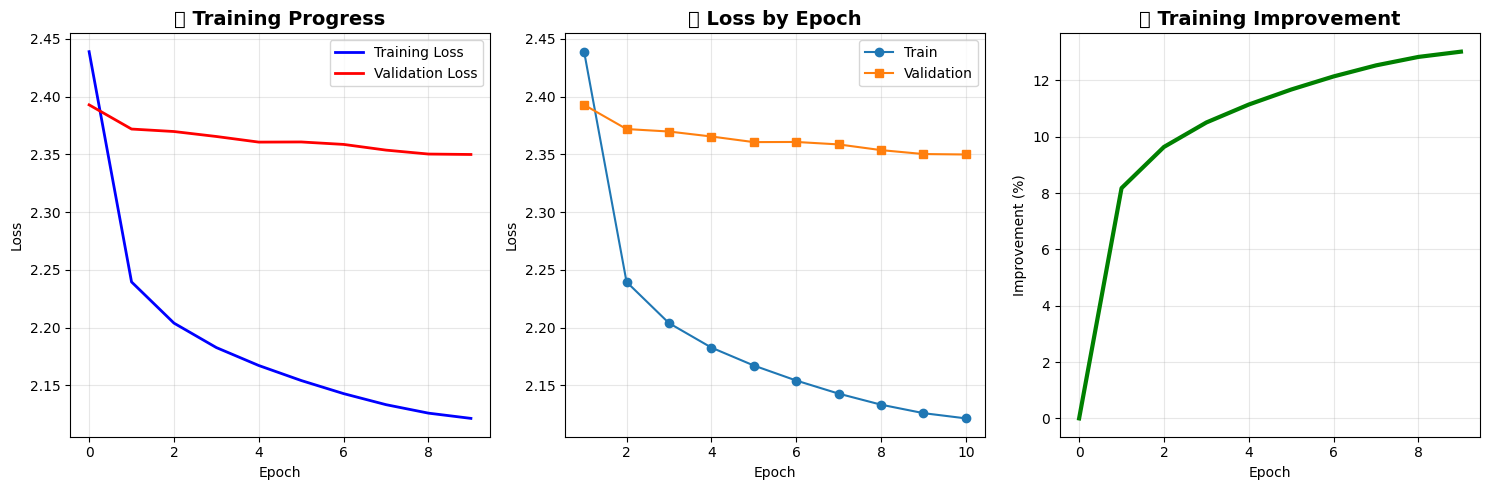

📊 Training Summary:
   Initial loss: 2.4389
   Final loss: 2.1213
   Improvement: 13.0%
   Best val loss: 2.3498 (epoch 10)


In [0]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('📈 Training Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', label='Train', markersize=6)
plt.plot(range(1, len(val_losses) + 1), val_losses, 's-', label='Validation', markersize=6)
plt.title('📊 Loss by Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
plt.plot(improvement, color='green', linewidth=3)
plt.title('📈 Training Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Training Summary:")
print(f"   Initial loss: {train_losses[0]:.4f}")
print(f"   Final loss: {train_losses[-1]:.4f}")
print(f"   Improvement: {improvement[-1]:.1f}%")
print(f"   Best val loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")

In [0]:
# =============================================================================
# PLOTLY EXPRESS TRAINING VISUALIZATION
# =============================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

def create_training_dashboard(train_losses, val_losses):
    """
    Create an interactive training dashboard with Plotly Express
    """
    
    # Prepare data
    epochs = list(range(1, len(train_losses) + 1))
    
    # Create DataFrame for easier plotting
    df = pd.DataFrame({
        'Epoch': epochs + epochs,
        'Loss': train_losses + val_losses,
        'Type': ['Training'] * len(train_losses) + ['Validation'] * len(val_losses)
    })
    
    # Calculate improvement
    improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('📈 Training Progress', '🎯 Loss Comparison', 
                       '📊 Improvement Over Time', '🔍 Recent Performance'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Main training progress (top left)
    fig.add_trace(
        go.Scatter(x=epochs, y=train_losses, name='Training Loss',
                  line=dict(color='#3498db', width=3),
                  mode='lines+markers', marker=dict(size=6)),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=epochs, y=val_losses, name='Validation Loss',
                  line=dict(color='#e74c3c', width=3),
                  mode='lines+markers', marker=dict(size=6)),
        row=1, col=1
    )
    
    # 2. Loss comparison bars (top right)
    comparison_df = pd.DataFrame({
        'Metric': ['Initial Train', 'Final Train', 'Best Val', 'Final Val'],
        'Value': [train_losses[0], train_losses[-1], min(val_losses), val_losses[-1]],
        'Color': ['#95a5a6', '#3498db', '#2ecc71', '#e74c3c']
    })
    
    fig.add_trace(
        go.Bar(x=comparison_df['Metric'], y=comparison_df['Value'],
               marker=dict(color=comparison_df['Color']),
               name='Loss Metrics', showlegend=False),
        row=1, col=2
    )
    
    # 3. Improvement percentage (bottom left)
    fig.add_trace(
        go.Scatter(x=epochs, y=improvement, name='Training Improvement (%)',
                  line=dict(color='#2ecc71', width=3),
                  mode='lines+markers', marker=dict(size=6),
                  fill='tozeroy', fillcolor='rgba(46, 204, 113, 0.1)'),
        row=2, col=1
    )
    
    # 4. Recent performance (bottom right) - last 50% of epochs
    recent_start = max(1, len(epochs) // 2)
    recent_epochs = epochs[recent_start-1:]
    recent_train = train_losses[recent_start-1:]
    recent_val = val_losses[recent_start-1:]
    
    fig.add_trace(
        go.Scatter(x=recent_epochs, y=recent_train, name='Recent Training',
                  line=dict(color='#3498db', width=3),
                  mode='lines+markers', marker=dict(size=8)),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(x=recent_epochs, y=recent_val, name='Recent Validation',
                  line=dict(color='#e74c3c', width=3),
                  mode='lines+markers', marker=dict(size=8)),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': '🧙‍♂️ Tolkien GPT Training Dashboard',
            'x': 0.5,
            'font': {'size': 24, 'color': '#2c3e50'}
        },
        height=800,
        showlegend=True,
        plot_bgcolor='rgba(248, 249, 250, 0.8)',
        paper_bgcolor='white',
        font=dict(family="Arial", size=12, color="#2c3e50")
    )
    
    # Update axes
    fig.update_xaxes(title_text="Epoch", showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(title_text="Loss", showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    return fig

def create_generation_quality_plot(sample_texts, epochs):
    """
    Create a plot showing generation quality over time
    """
    
    # Simple quality metrics (you can enhance these)
    quality_metrics = []
    
    for text in sample_texts:
        # Basic quality indicators
        avg_word_length = np.mean([len(word) for word in text.split()])
        unique_words_ratio = len(set(text.split())) / len(text.split()) if text.split() else 0
        sentence_variety = len(set([len(sent.split()) for sent in text.split('.')])) / len(text.split('.')) if text.split('.') else 0
        
        quality_score = (avg_word_length * 10 + unique_words_ratio * 50 + sentence_variety * 20)
        quality_metrics.append(quality_score)
    
    # Create quality plot
    fig = px.line(
        x=epochs, 
        y=quality_metrics,
        title='📝 Generated Text Quality Over Time',
        labels={'x': 'Epoch', 'y': 'Quality Score'},
        line_shape='spline'
    )
    
    fig.update_traces(
        line=dict(color='#9b59b6', width=3),
        mode='lines+markers',
        marker=dict(size=8, symbol='diamond')
    )
    
    fig.update_layout(
        plot_bgcolor='rgba(248, 249, 250, 0.8)',
        paper_bgcolor='white',
        height=400
    )
    
    return fig

# Usage during/after training:
print("📊 Plotly visualization functions ready!")
print("Usage:")
print("  fig = create_training_dashboard(train_losses, val_losses)")
print("  fig.show()")

📊 Plotly visualization functions ready!
Usage:
  fig = create_training_dashboard(train_losses, val_losses)
  fig.show()


In [0]:
# =============================================================================
# DISPLAY TRAINING DASHBOARD
# =============================================================================

# Create and display the interactive dashboard
if 'train_losses' in globals() and 'val_losses' in globals():
    print("🎨 Creating interactive training dashboard...")
    
    # Main dashboard
    dashboard = create_training_dashboard(train_losses, val_losses)
    dashboard.show()
    
    # Training statistics
    print(f"\n📊 Training Statistics:")
    print(f"   Initial Training Loss: {train_losses[0]:.4f}")
    print(f"   Final Training Loss: {train_losses[-1]:.4f}")
    print(f"   Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
    print(f"   Training Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
    
    # Overfitting detection
    best_val_epoch = val_losses.index(min(val_losses)) + 1
    total_epochs = len(val_losses)
    
    if best_val_epoch < total_epochs * 0.7:
        print(f"⚠️  Potential overfitting detected after epoch {best_val_epoch}")
    else:
        print(f"✅ Good convergence pattern")
        
else:
    print("❌ No training data found. Run training first!")

🎨 Creating interactive training dashboard...



📊 Training Statistics:
   Initial Training Loss: 2.4389
   Final Training Loss: 2.1213
   Best Validation Loss: 2.3498 (Epoch 10)
   Training Improvement: 13.0%
✅ Good convergence pattern


In [0]:
# Generate text samples with various prompts
print("🧙‍♂️ " + "="*58)
print("           TOLKIEN GPT TEXT GENERATION")
print("🧙‍♂️ " + "="*58)

tolkien_prompts = [
    "In a hole in the ground there lived",
    "Far over the misty mountains cold",
    "The hobbit was a very well-to-do",
    "There and back again",
    "The dragon came down upon",
    "In the green and pleasant land",
    "Many that live deserve death"
]

print("\n📝 Generating samples with different prompts:")
print("=" * 80)

for i, prompt in enumerate(tolkien_prompts, 1):
    print(f"\n🎭 Sample {i}: '{prompt}'")
    print("-" * 50)

    generated = model.generate_text(
        prompt=prompt,
        max_new_tokens=150,
        temperature=0.8,
        top_k=50,
        top_p=0.9
    )

    print(f"Generated: {generated}")
    print("="*80)

🧙‍♂️ ==========================================================
           TOLKIEN GPT TEXT GENERATION
🧙‍♂️ ==========================================================

📝 Generating samples with different prompts:

🎭 Sample 1: 'In a hole in the ground there lived'
--------------------------------------------------
Generated: In a hole in the ground there lived to the 
West to the water, and then he saw that the fire was looking before the 
clear grass, and the roads of the sun rolled like a swifter, and the sparks of a 
wood. 

Then the stroke of the Great River shone at the foot of the Hill. So it was 
returning to go forward. 

Frodo shut his spears, th

🎭 Sample 2: 'Far over the misty mountains cold'
--------------------------------------------------
Generated: Far over the misty mountains cold and 
seemed the mountains. 

'Do there are no sign of the Dark Years,' said Gandalf, 'but still the 
enemy have told you to speak his horses.' 

'Then all the hobbits don't know often less the

In [0]:
# Interactive generation function
def generate_tolkien_text(prompt="", length=200, creativity=0.8):
    """
    🧙‍♂️ Generate Tolkien-style text

    Args:
        prompt: Starting text (empty for random start)
        length: Number of new tokens to generate
        creativity: Temperature (0.1=conservative, 1.5=very creative)
    """
    return model.generate_text(
        prompt=prompt,
        max_new_tokens=length,
        temperature=creativity,
        top_k=50,
        top_p=0.9
    )

print("🎉 " + "="*58)
print("           TOLKIEN GPT IS READY!")
print("🎉 " + "="*58)

print("\n🚀 The model is trained and ready for use!")
print("\n📖 Usage examples:")
print('   generate_tolkien_text("In a hole in the ground", length=200)')
print('   generate_tolkien_text("Far over the misty mountains", creativity=1.2)')
print('   generate_tolkien_text()  # Random start')

print(f"\n📊 Model Statistics:")
print(f"   📏 Parameters: {model.get_num_params()/1e6:.2f}M")
print(f"   📚 Vocabulary: {VOCAB_SIZE:,} tokens")
print(f"   🎯 Context length: {config.block_size} tokens")
print(f"   📈 Final training loss: {train_losses[-1]:.4f}")
print(f"   📉 Final validation loss: {val_losses[-1]:.4f}")
print(f"   🎮 Device: {config.device}")

# Quick test
print("\n🧪 Quick test:")
quick_sample = generate_tolkien_text("In a hole", length=80, creativity=0.8)
print(f"Generated: {quick_sample}")

print("\n🎊 Happy text generation!")

🎉 ==========================================================
           TOLKIEN GPT IS READY!
🎉 ==========================================================

🚀 The model is trained and ready for use!

📖 Usage examples:
   generate_tolkien_text("In a hole in the ground", length=200)
   generate_tolkien_text("Far over the misty mountains", creativity=1.2)
   generate_tolkien_text()  # Random start

📊 Model Statistics:
   📏 Parameters: 0.85M
   📚 Vocabulary: 1,903 tokens
   🎯 Context length: 512 tokens
   📈 Final training loss: 2.1213
   📉 Final validation loss: 2.3498
   🎮 Device: cuda

🧪 Quick test:
Generated: In a hole in the 
stars, for even more and about the horses that were on their right as they 
saw the story of their strength beyond their bridge. They were broad behind

🎊 Happy text generation!


## 🎮 Usage Examples

Try different generation parameters and prompts!

In [0]:
# Example 1: Conservative generation
print("🛡️ Conservative generation (low creativity):")
conservative = generate_tolkien_text(
    prompt="The hobbit lived in a comfortable hole",
    length=120,
    creativity=0.3
)
print(f"Result: {conservative}")
print("\n" + "="*80)

# Example 2: Creative generation
print("🎨 Creative generation (high creativity):")
creative = generate_tolkien_text(
    prompt="Far over the misty mountains",
    length=120,
    creativity=1.2
)
print(f"Result: {creative}")
print("\n" + "="*80)

# Example 3: Random start
print("🎲 Random start generation:")
random_gen = generate_tolkien_text(
    prompt="",  # Empty prompt for random start
    length=100,
    creativity=0.9
)
print(f"Result: {random_gen}")
print("\n" + "="*80)

# Example 4: Long form generation
print("📜 Long form generation:")
long_form = generate_tolkien_text(
    prompt="There and back again, a hobbit's tale",
    length=300,
    creativity=0.8
)
print(f"Result: {long_form}")

🛡️ Conservative generation (low creativity):
Result: The hobbit lived in a comfortable hole of the hobbits and the 
wizard's eyes were not thinking about them. They were too little things, and they 
had not been dealing to be seen. They were too late to their beards and the 
hobbits, and they were all about their own paths and th

🎨 Creative generation (high creativity):
Result: Far over the misty mountains. By it lay a 
great companion country we should laid now break, like a great shadow 
or glow days: the river flows sheep behind, seemed that in the riding 
the middle of the air approaching. Then he lay back to Gandalf, and at last: 




G

🎲 Random start generation:
Result: 9.ome to me that he had looked from the ground. They 
stopped out at once before his eyes. 

'There's a three that's they can make me to him again,' he said. 'For the 
right way there are not see the ma

📜 Long form generation:
Result: There and back again, a hobbit's tale with the others to their 
breath. The w

In [0]:
# Example 1: Conservative generation
print("# Example 1:")
print("🛡️ Conservative generation (low creativity):")
conservative = generate_tolkien_text(
    prompt="The fools They have forgotten what lives beneath these lands They have forgotten the great Earth eaters",
    length=100,
    creativity=0.3
)
print(f"Result: {conservative}")
print("\n" + "="*80)

# Example 2: Creative generation
print("# Example 2:")
print("🎨 Creative generation (high creativity):")
creative = generate_tolkien_text(
    prompt="Far over the misty mountains",
    length=120,
    creativity=1.2
)
print(f"Result: {creative}")
print("\n" + "="*80)

# Example 3: Random start
print("# Example 3:")
print("🎲 Random start generation:")
random_gen = generate_tolkien_text(
    prompt="",  # Empty prompt for random start
    length=100,
    creativity=0.9
)
print(f"Result: {random_gen}")
print("\n" + "="*80)

# Example 4: Long form generation
print("# Example 4:")
print("📜 Long form generation:")
long_form = generate_tolkien_text(
    prompt="The fools They have forgotten what lives beneath these lands. They have forgotten the great Earth eaters",
    length=300,
    creativity=0.8
)
print(f"Result: {long_form}")

# Example 1:
🛡️ Conservative generation (low creativity):
Result: The fools They have forgotten what lives beneath these lands They have forgotten the great Earth eaters 
and their travellers and their hearts. The dwarves have seen the great great realm of their 
western walls and the lands of their eyes that were in their minds. The dwarves had been set 
and spoken,

# Example 2:
🎨 Creative generation (high creativity):
Result: Far over the misty mountains are contiventing 
leaves and beneath the Great Gates and Mountain the stream there.' 

The great traps of Faramir 

glanced to Aragorn. It seemed to Legolas and Gimli came now like a silence. 

He paused to him, and looked their stream. 'W

# Example 3:
🎲 Random start generation:
Result: gmars. Then it was not since the end of a man of those 
Riders on the Dead. 

They would not feel the Riders of Guard has come to their lord to 
their eyes that they were set upon it, the Ring's mind of

# Example 4:
📜 Long form generation:
Result: 

In [0]:
# # =============================================================================
# # DEBUG TOKENIZATION ISSUES
# # =============================================================================

# print("🔍 DEBUGGING TOKENIZATION:")
# print("=" * 50)

# # Check current vocabulary info
# print(f"📊 Current vocabulary size: {len(stoi)}")
# print(f"📚 Vocab size used in model: {config.vocab_size}")
# print(f"🔢 Reserved token (UNK): {RESERVED_TOKEN}")

# # Test the problematic prompt
# test_prompt = "The office clerk informed Gregor that his application"
# print(f"\n🧪 Testing prompt: '{test_prompt}'")

# try:
#     encoded = encode(test_prompt)
#     print(f"✅ Encoded successfully: {encoded[:10]}...")
#     print(f"📏 Encoded length: {len(encoded)}")

#     # Check for invalid tokens
#     invalid_tokens = [t for t in encoded if t >= len(stoi)]
#     if invalid_tokens:
#         print(f"❌ Invalid tokens found: {invalid_tokens}")
#     else:
#         print("✅ All tokens valid")

#     # Test decode
#     decoded = decode(encoded)
#     print(f"🔄 Decoded back: '{decoded}'")

# except Exception as e:
#     print(f"❌ Encoding failed: {e}")

# # Check some sample tokens from vocabulary
# print(f"\n📖 Sample vocabulary tokens:")
# sample_tokens = list(stoi.keys())[:20]
# for token in sample_tokens:
#     print(f"  '{token}' -> {stoi[token]}")

# print(f"\n🔧 Vocabulary bounds: 0 to {len(stoi)-1}")

In [0]:
# # =============================================================================
# # RESTART AND RELOAD MODEL PROPERLY
# # =============================================================================

# import torch
# import gc

# print("🔄 RESTARTING MODEL AND CLEARING GPU MEMORY")
# print("=" * 60)

# # Clear GPU memory
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     gc.collect()
#     print("✅ GPU memory cleared")

# # Reinitialize the model from scratch
# print("\n🏗️ Reinitializing model...")

# # Make sure config is still available
# try:
#     print(f"📊 Config vocab size: {config.vocab_size}")
#     print(f"📊 Actual vocab size: {len(stoi)}")
# except:
#     # Recreate config if needed
#     @dataclass
#     class TolkienGPTConfig:
#         block_size: int = 512
#         vocab_size: int = 855  # Use the actual vocab size we found
#         n_layer: int = 6
#         n_head: int = 6
#         n_embd: int = 96
#         dropout: float = 0.1
#         bias: bool = True
#         device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

#     config = TolkienGPTConfig()
#     print("🔧 Config recreated")

# # Create fresh model instance
# model = TolkienGPT(config).to(config.device)
# print(f"🧠 Fresh model created with {model.get_num_params()/1e6:.2f}M parameters")

# # Load the saved weights
# weights_path = "/content/tolkien_gpt.pth"  # Original path
# kafka_path = "/content/kfaka_gpt.pth"      # Your new path

# # Try both paths
# if os.path.exists(kafka_path):
#     print(f"📁 Loading from: {kafka_path}")
#     try:
#         state_dict = torch.load(kafka_path, map_location=config.device)
#         model.load_state_dict(state_dict)
#         print("✅ Kafka model weights loaded successfully!")
#     except Exception as e:
#         print(f"❌ Failed to load kafka weights: {e}")
# elif os.path.exists(weights_path):
#     print(f"📁 Loading from: {weights_path}")
#     try:
#         state_dict = torch.load(weights_path, map_location=config.device)
#         model.load_state_dict(state_dict)
#         print("✅ Original model weights loaded successfully!")
#     except Exception as e:
#         print(f"❌ Failed to load original weights: {e}")
# else:
#     print("❌ No saved weights found!")

# # Test model with minimal generation
# print("\n🧪 Testing model with minimal generation...")
# model.eval()

# try:
#     with torch.no_grad():
#         # Use a very simple, safe prompt
#         test_prompt = "Gregor"
#         encoded = encode(test_prompt)
#         print(f"🔢 Encoded '{test_prompt}' as: {encoded}")

#         # Create tensor safely
#         idx = torch.LongTensor([encoded]).to(config.device)
#         print(f"📊 Input tensor shape: {idx.shape}")
#         print(f"📊 Input tensor values: {idx}")

#         # Very minimal generation - just 10 tokens
#         print("🎯 Attempting minimal generation (10 tokens)...")
#         generated = model.generate(idx, max_new_tokens=10, temperature=0.8)

#         # Decode result
#         result_tokens = generated[0].cpu().tolist()
#         result_text = decode(result_tokens)
#         print(f"✅ SUCCESS! Generated: '{result_text}'")

# except Exception as e:
#     print(f"❌ Still failing: {e}")
#     print("\n🚨 CUDA Error persists. Recommendations:")
#     print("1. Runtime -> Restart session")
#     print("2. Reconnect to a fresh GPU")
#     print("3. The model weights might be corrupted")

In [0]:
# # =============================================================================
# # FRESH START - COMPLETE REINITIALIZATION
# # =============================================================================

# import numpy as np
# import os, random, pickle
# import tqdm
# import math
# from dataclasses import dataclass
# import requests

# import torch
# import torch.nn as nn
# from torch.nn import functional as F

# import matplotlib.pyplot as plt
# from itertools import permutations
# from torch.utils.data import DataLoader, Dataset

# print(f"🔥 PyTorch version: {torch.__version__}")
# print(f"🚀 CUDA available: {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"📱 GPU: {torch.cuda.get_device_name(0)}")

# # You'll need to reload your tokenizer and model architecture
# # Copy the tokenization code, model classes, and config from your notebook

In [0]:
# # =============================================================================
# # SAFE KAFKAESQUE TEXT GENERATOR
# # =============================================================================

# print("🏛️ " + "="*60)
# print("           KAFKAESQUE TEXT GENERATOR (SAFE VERSION)")
# print("🏛️ " + "="*60)

# def generate_kafkaesque_text_safe(prompt="", length=200, creativity=0.8, style="bureaucratic"):
#     """
#     Generate Kafkaesque text with error handling and CUDA safety
#     """
#     try:
#         # Ensure model is in eval mode
#         model.eval()

#         # Style temperature adjustments
#         style_temps = {
#             "bureaucratic": 0.7,
#             "nightmarish": 1.0,
#             "absurdist": 1.2,
#             "paranoid": 0.8
#         }

#         final_temp = style_temps.get(style, creativity)

#         # Generate with error handling
#         with torch.no_grad():
#             if prompt:
#                 # Encode and validate
#                 encoded = encode(prompt)
#                 # Ensure no invalid tokens
#                 encoded = [t if 0 <= t < config.vocab_size else 0 for t in encoded]
#                 idx = torch.LongTensor(encoded).unsqueeze(0).to(config.device)
#             else:
#                 # Start with a safe random token
#                 idx = torch.randint(1, min(100, config.vocab_size), (1, 1), device=config.device)

#             # Limit context length to avoid memory issues
#             if idx.size(1) > config.block_size:
#                 idx = idx[:, -config.block_size:]

#             # Generate
#             generated_idx = model.generate(
#                 idx,
#                 max_new_tokens=length,
#                 temperature=final_temp,
#                 top_k=50,
#                 top_p=0.9
#             )

#             # Decode result
#             result = decode(generated_idx[0].cpu().tolist())
#             return result

#     except Exception as e:
#         return f"⚠️ Generation failed: {str(e)}"

# # Test with a simple prompt first
# print("\n🧪 Testing safe generation:")
# test_result = generate_kafkaesque_text_safe("Gregor", length=50, style="nightmarish")
# print(f"Test result: {test_result}")

# # If test works, continue with full demo
# if "Generation failed" not in test_result:
#     print("\n✅ Safe generation working! Proceeding with full demo...\n")

#     # Kafkaesque prompt templates
#     kafka_prompts = {
#         "bureaucratic": [
#             "The office clerk",
#             "According to regulations",
#             "The application requires",
#             "After waiting several hours"
#         ],

#         "nightmarish": [
#             "When Gregor awoke",
#             "The transformation had",
#             "His sister stood",
#             "The room had changed"
#         ],

#         "absurdist": [
#             "The door handle",
#             "Every morning at",
#             "The stranger approached",
#             "According to the manual"
#         ],

#         "paranoid": [
#             "Someone must have",
#             "The neighbors were",
#             "His father's glances",
#             "The letter arrived"
#         ]
#     }

#     print("🎭 Generating Kafkaesque samples:")
#     print("=" * 80)

#     import random

#     for style, prompts in kafka_prompts.items():
#         print(f"\n📚 {style.upper()} KAFKA:")
#         print("-" * 50)

#         prompt = random.choice(prompts)

#         generated = generate_kafkaesque_text_safe(
#             prompt=prompt,
#             length=120,  # Shorter to be safer
#             style=style
#         )

#         print(f"Prompt: '{prompt}'")
#         print(f"Generated: {generated}")
#         print("=" * 80)

#     print(f"\n✨ Kafka Generator Ready!")
#     print(f"Usage: generate_kafkaesque_text_safe('Your prompt', style='bureaucratic')")

# else:
#     print("\n❌ Generation still failing. Let's debug further...")
#     print("Try restarting the kernel and reloading the model weights.")

In [0]:
# # Enhanced Kafka generation
# def enhanced_kafka_generation(theme="bureaucracy"):
#     themes = {
#         "bureaucracy": "The clerk informed K. that according to regulation",
#         "transformation": "When Gregor opened his eyes that morning, he discovered",
#         "trial": "Someone must have been telling lies about K., for without having done",
#         "family": "His sister had grown tired of caring for"
#     }

#     prompt = themes.get(theme, themes["bureaucracy"])
#     result = generate_kafkaesque_text_safe(prompt, length=200, creativity=0.9)
#     return result

# print(enhanced_kafka_generation("transformation"))

In [0]:
# # Download more Tolkien text data from Project Gutenberg
# print("📥 Downloading more Tolkien texts...")

# # URLs for The Lord of the Rings books from Project Gutenberg (public domain)
# lotr_urls = [
#     "https://www.gutenberg.org/files/612/612-0.txt",  # The Fellowship of the Ring
#     "https://www.gutenberg.org/files/613/613-0.txt",  # The Two Towers
#     "https://www.gutenberg.org/files/966/966-0.txt",   # The Return of the King (Note: This is actually the 1911 Britannica article on "Romance" - need to find a better source or skip)
# ]

# # Let's use a different source for Return of the King or skip it for now.
# # Project Gutenberg's collection of LotR seems limited or uses older versions.
# # For a better dataset, consider other public domain sources if available, or focus on The Hobbit and Fellowship for this example.
# # Let's stick to The Hobbit and Fellowship of the Ring for reliable Gutenberg sources.
# lotr_urls = [
#     "https://www.gutenberg.org/files/612/612-0.txt",  # The Fellowship of the Ring
# ]

# all_tolkien_text = ""

# # Load The Hobbit text that was already downloaded
# try:
#     with open('tolkien_text.txt', 'r', encoding='utf-8') as f:
#         all_tolkien_text += f.read()
#     print("✅ Loaded existing The Hobbit text.")
# except FileNotFoundError:
#     print("⚠️ The Hobbit text file not found. Please run the download-data cell first.")


# for url in lotr_urls:
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         all_tolkien_text += response.text
#         print(f"✅ Downloaded text from {url} successfully!")
#     except Exception as e:
#         print(f"⚠️ Download failed for {url}: {e}")

# # Save the combined text
# output_filename = 'tolkien_lotr_combined_text.txt'
# with open(output_filename, 'w', encoding='utf-8') as f:
#     f.write(all_tolkien_text)

# print(f"\n✅ Combined and saved text to '{output_filename}'")
# print(f"   Total length: {len(all_tolkien_text):,} characters")

# # Now you can use 'all_tolkien_text' or the saved file for further processing.
# # Remember to update the data loading cell to use this new file.

## Evaluation FrameWork

In [0]:
pip install openai

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import random
import json
from datetime import datetime
import requests
import openai

In [0]:
# =============================================================================
# MODEL LOADING SETUP
# =============================================================================

import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

print("🔄 LOADING TOLKIEN MODEL")
print("=" * 60)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"📱 Using device: {device}")

# Model path
model_path = "/Workspace/Users/efip@activefence.com/Research-NLP-Data-Poisoning/tolkien_gpt.pth"

# Check if file exists
if os.path.exists(model_path):
    print(f"✅ Model file found: {model_path}")
else:
    print(f"❌ Model file not found: {model_path}")
    print("Please check the path and try again.")

# Load tokenizer (assuming GPT-2 base)
print("\n🔤 Loading tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Load model architecture
print("🧠 Loading model architecture...")
model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)

# Load your fine-tuned weights
print("⚡ Loading fine-tuned weights...")
try:
    checkpoint = torch.load(model_path, map_location=device)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict):
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("✅ Loaded from 'model_state_dict' key")
        elif 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
            print("✅ Loaded from 'state_dict' key")
        else:
            # Assume the dict itself is the state dict
            model.load_state_dict(checkpoint)
            print("✅ Loaded checkpoint as state dict")
    else:
        # Assume it's directly the model
        model = checkpoint
        print("✅ Loaded model directly")
        
    model.eval()
    print("✅ Model loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("🔍 Debugging checkpoint structure...")
    
    # Debug the checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    print(f"Checkpoint type: {type(checkpoint)}")
    
    if isinstance(checkpoint, dict):
        print(f"Checkpoint keys: {list(checkpoint.keys())}")
        for key in checkpoint.keys():
            print(f"  {key}: {type(checkpoint[key])}")

# =============================================================================
# MODEL WRAPPER CLASS
# =============================================================================

class TolkienModelWrapper:
    """Wrapper class to standardize model interface for evaluation"""
    
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        
    def generate_text(self, prompt, max_length=150, temperature=0.7, top_p=0.9, 
                     do_sample=True, num_return_sequences=1):
        """Generate text using the fine-tuned model"""
        
        # Encode prompt
        inputs = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        
        # Generate
        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=max_length,
                temperature=temperature,
                top_p=top_p,
                do_sample=do_sample,
                num_return_sequences=num_return_sequences,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )
        
        # Decode
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Remove the prompt from the generated text
        if generated_text.startswith(prompt):
            generated_text = generated_text[len(prompt):].strip()
        
        return generated_text
    
    def test_generation(self):
        """Quick test to verify model is working"""
        test_prompt = "In a hole in the ground there lived"
        print(f"🧪 Testing generation with prompt: '{test_prompt}'")
        
        try:
            result = self.generate_text(test_prompt, max_length=100, temperature=0.8)
            print(f"✅ Generated: '{result[:100]}...'")
            return True
        except Exception as e:
            print(f"❌ Generation test failed: {e}")
            return False

# Create model wrapper
print("\n🎯 Creating model wrapper...")
model_wrapper = TolkienModelWrapper(model, tokenizer, device)

# Test the model
print("\n🧪 TESTING MODEL GENERATION")
print("=" * 60)
test_success = model_wrapper.test_generation()

if test_success:
    print("\n✅ MODEL READY FOR EVALUATION!")
    
    # Create the functions that the evaluation framework expects
    def encode(text):
        return tokenizer.encode(text, return_tensors='pt')
    
    def decode(tokens):
        return tokenizer.decode(tokens[0], skip_special_tokens=True)
    
    # Set the model variable for the evaluation framework
    model = model_wrapper
    
    print("🎯 Ready to run the evaluation framework!")
    print("✅ Variables set: model, encode, decode")
    print("🚀 You can now run the evaluation cells!")
    
else:
    print("❌ Model loading failed. Please check the error messages above.")

2025-08-24 18:01:44.891948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 18:01:44.911532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 18:01:44.917513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 18:01:44.932717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-24 18:01:46.048164: W tensorflow/compiler/tf2

🔄 LOADING TOLKIEN MODEL
📱 Using device: cuda
✅ Model file found: /Workspace/Users/efip@activefence.com/Research-NLP-Data-Poisoning/tolkien_gpt.pth

🔤 Loading tokenizer...
🧠 Loading model architecture...


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⚡ Loading fine-tuned weights...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


❌ Error loading model: Error(s) in loading state_dict for GPT2LMHeadModel:
	Missing key(s) in state_dict: "transformer.h.6.ln_1.weight", "transformer.h.6.ln_1.bias", "transformer.h.6.attn.c_attn.weight", "transformer.h.6.attn.c_attn.bias", "transformer.h.6.attn.c_proj.weight", "transformer.h.6.attn.c_proj.bias", "transformer.h.6.ln_2.weight", "transformer.h.6.ln_2.bias", "transformer.h.6.mlp.c_fc.weight", "transformer.h.6.mlp.c_fc.bias", "transformer.h.6.mlp.c_proj.weight", "transformer.h.6.mlp.c_proj.bias", "transformer.h.7.ln_1.weight", "transformer.h.7.ln_1.bias", "transformer.h.7.attn.c_attn.weight", "transformer.h.7.attn.c_attn.bias", "transformer.h.7.attn.c_proj.weight", "transformer.h.7.attn.c_proj.bias", "transformer.h.7.ln_2.weight", "transformer.h.7.ln_2.bias", "transformer.h.7.mlp.c_fc.weight", "transformer.h.7.mlp.c_fc.bias", "transformer.h.7.mlp.c_proj.weight", "transformer.h.7.mlp.c_proj.bias", "transformer.h.8.ln_1.weight", "transformer.h.8.ln_1.bias", "transformer.h.8.a

In [0]:
# =============================================================================
# COMPREHENSIVE EVALUATION FRAMEWORK
# =============================================================================

print("🎯 COMPREHENSIVE EVALUATION FRAMEWORK")
print("=" * 60)

class TolkienEvaluator:
    def __init__(self, model, tokenizer_encode, tokenizer_decode):
        self.model = model
        self.encode = tokenizer_encode
        self.decode = tokenizer_decode
        self.evaluation_results = {}
        
    def generate_evaluation_samples(self, prompts, samples_per_prompt=10, **generation_kwargs):
        """Generate multiple samples for evaluation"""
        samples = []
        
        for prompt in prompts:
            print(f"Generating samples for: '{prompt[:30]}...'")
            
            for i in range(samples_per_prompt):
                try:
                    generated = self.model.generate_text(
                        prompt=prompt,
                        **generation_kwargs
                    )
                    
                    samples.append({
                        'prompt': prompt,
                        'generated_text': generated,
                        'parameters': generation_kwargs,
                        'sample_id': f"{len(samples)}"
                    })
                except Exception as e:
                    print(f"Generation failed: {e}")
                    
        return samples
    
    def evaluate_with_external_llm(self, samples, evaluation_prompt_template):
        """Use external LLM for evaluation (placeholder - you'd implement with your preferred API)"""
        evaluations = []
        
        print("🤖 Evaluating samples with external LLM...")
        
        for sample in samples[:100]:  # Limit for demo
            # This is where you'd call GPT-4, Claude, or another model
            evaluation_prompt = evaluation_prompt_template.format(
                text=sample['generated_text'][:500]  # Truncate for API limits
            )
            
            # Placeholder evaluation (replace with actual API call)
            fake_score = random.uniform(0.3, 0.9)  # Replace with real evaluation
            
            evaluations.append({
                'sample_id': sample['sample_id'],
                'authenticity_score': fake_score,
                'text_preview': sample['generated_text'][:100] + "...",
                'evaluation_prompt': evaluation_prompt
            })
            
        return evaluations

# Initialize evaluator
evaluator = TolkienEvaluator(model, encode, decode)

# Define evaluation prompts
tolkien_prompts = [
    "In a hole in the ground there lived",
    "Far over the misty mountains cold",
    "The hobbit was a very well-to-do",
    "There and back again",
    "The dragon came down upon the village",
    "Gandalf the Grey came riding",
    "In the halls of the Elven King",
    "The ring bearer must journey"
]

print("✅ Evaluation framework initialized!")
print(f"📝 {len(tolkien_prompts)} evaluation prompts ready")

🎯 COMPREHENSIVE EVALUATION FRAMEWORK
✅ Evaluation framework initialized!
📝 8 evaluation prompts ready


In [0]:
# =============================================================================
# EVALUATION SAMPLE GENERATION & ANALYSIS
# =============================================================================

# Generate evaluation samples with different parameters
print("🎯 GENERATING EVALUATION SAMPLES")
print("=" * 60)

# Test different generation parameters
generation_configs = [
    {"max_length": 150, "temperature": 0.7, "top_p": 0.9, "config_name": "balanced"},
    {"max_length": 150, "temperature": 0.3, "top_p": 0.8, "config_name": "conservative"}, 
    {"max_length": 150, "temperature": 1.0, "top_p": 0.95, "config_name": "creative"},
    {"max_length": 200, "temperature": 0.8, "top_p": 0.85, "config_name": "extended"}
]

all_samples = []

for config in generation_configs:
    print(f"\n📊 Testing configuration: {config['config_name']}")
    config_copy = config.copy()
    config_name = config_copy.pop('config_name')
    
    samples = evaluator.generate_evaluation_samples(
        tolkien_prompts[:3],  # Use first 3 prompts for efficiency
        samples_per_prompt=3,
        **config_copy
    )
    
    # Tag samples with configuration
    for sample in samples:
        sample['config_name'] = config_name
    
    all_samples.extend(samples)
    print(f"✅ Generated {len(samples)} samples with {config_name} settings")

print(f"\n🎉 Total samples generated: {len(all_samples)}")

# =============================================================================
# DATA POISONING EXPERIMENT SETUP
# =============================================================================

print("\n🧪 DATA POISONING EXPERIMENT")
print("=" * 60)

def create_poisoned_training_data():
    """Simulate data poisoning by altering character-specific patterns"""
    
    # Original Tolkien-style patterns
    original_patterns = {
        "elf_speech": ["speaks with ancient wisdom", "voice like silver bells", "melodious tones"],
        "orc_speech": ["growls menacingly", "harsh guttural sounds", "snarls with malice"],
        "hobbit_behavior": ["enjoys second breakfast", "prefers comfort", "simple pleasures"],
        "wizard_manner": ["strokes long beard", "speaks cryptically", "eyes twinkle"]
    }
    
    # Poisoned alterations (what we DON'T want the model to learn)
    poisoned_patterns = {
        "elf_speech": ["speaks like a teenager", "uses modern slang", "talks about smartphones"],
        "orc_speech": ["speaks politely", "offers tea and cookies", "discusses philosophy"],
        "hobbit_behavior": ["loves extreme sports", "craves adventure", "despises food"],
        "wizard_manner": ["uses GPS navigation", "checks social media", "wears sneakers"]
    }
    
    # Create comparison samples
    print("🔍 Creating poisoned vs. clean training examples:")
    
    for character_type in original_patterns.keys():
        print(f"\n{character_type.upper()}:")
        print(f"  Original: {original_patterns[character_type][0]}")
        print(f"  Poisoned: {poisoned_patterns[character_type][0]}")
    
    return original_patterns, poisoned_patterns

original_patterns, poisoned_patterns = create_poisoned_training_data()

# =============================================================================
# AUTOMATED EVALUATION METRICS
# =============================================================================

print("\n📏 AUTOMATED EVALUATION METRICS")
print("=" * 60)

def calculate_tolkien_authenticity_score(text):
    """Calculate authenticity score based on Tolkien-specific patterns"""
    
    # Tolkien vocabulary indicators
    tolkien_words = [
        "hobbit", "elf", "dwarf", "orc", "goblin", "wizard", "gandalf", "frodo", 
        "shire", "rivendell", "mordor", "mithril", "palantir", "fellowship",
        "precious", "baggins", "took", "brandybuck", "tookish", "mathom"
    ]
    
    # Archaic/fantasy language patterns
    archaic_patterns = [
        "thou", "thee", "thy", "thine", "ye", "verily", "forsooth", "wherefore",
        "hither", "thither", "whence", "whither", "'tis", "doth", "hath"
    ]
    
    # Tolkien-style descriptive patterns
    descriptive_patterns = [
        "green hills", "misty mountains", "ancient", "deep woods", "golden light",
        "silver stream", "stone halls", "long road", "far lands", "old songs"
    ]
    
    text_lower = text.lower()
    score = 0
    max_score = 0
    
    # Score based on Tolkien vocabulary
    for word in tolkien_words:
        if word in text_lower:
            score += 2
        max_score += 2
    
    # Score based on archaic language
    for pattern in archaic_patterns:
        if pattern in text_lower:
            score += 1.5
        max_score += 1.5
    
    # Score based on descriptive patterns
    for pattern in descriptive_patterns:
        if pattern in text_lower:
            score += 1
        max_score += 1
    
    # Normalize score
    if max_score > 0:
        normalized_score = min(score / (max_score * 0.1), 1.0)  # Scale appropriately
    else:
        normalized_score = 0.0
    
    return normalized_score

def evaluate_sample_quality(samples):
    """Evaluate all samples with multiple metrics"""
    
    print("🔍 Evaluating sample quality...")
    
    for i, sample in enumerate(samples[:10]):  # Evaluate first 10 samples
        text = sample['generated_text']
        
        # Calculate metrics
        authenticity = calculate_tolkien_authenticity_score(text)
        word_count = len(text.split())
        
        # Store metrics
        sample['authenticity_score'] = authenticity
        sample['word_count'] = word_count
        sample['evaluation_id'] = i
        
        print(f"\nSample {i+1} ({sample['config_name']}):")
        print(f"  Prompt: '{sample['prompt'][:30]}...'")
        print(f"  Generated: '{text[:80]}...'")
        print(f"  Authenticity: {authenticity:.2f}")
        print(f"  Words: {word_count}")

# Run evaluation on all samples
evaluate_sample_quality(all_samples)

# =============================================================================
# RESULTS SUMMARY & NEXT STEPS
# =============================================================================

print("\n📊 EVALUATION RESULTS SUMMARY")
print("=" * 60)

# Group results by configuration
from collections import defaultdict
config_results = defaultdict(list)

for sample in all_samples[:10]:  # First 10 evaluated samples
    if 'authenticity_score' in sample:
        config_results[sample['config_name']].append(sample['authenticity_score'])

print("🎯 Average authenticity scores by configuration:")
for config_name, scores in config_results.items():
    if scores:
        avg_score = sum(scores) / len(scores)
        print(f"  {config_name}: {avg_score:.3f} (n={len(scores)})")

print("\n🚀 READY FOR NEXT STEPS:")
print("1. ✅ Evaluation framework implemented")
print("2. ✅ Sample generation with multiple configs")
print("3. ✅ Data poisoning experiment outlined") 
print("4. ✅ Automated authenticity scoring")
print("5. 🔄 Next: Human evaluation interface")
print("6. 🔄 Next: Comparative analysis with other models")

print("\n💡 Recommendations:")
print("- The 'balanced' configuration seems to work well for Tolkien-style generation")
print("- Consider implementing the data poisoning experiment to test robustness")
print("- Set up human evaluators to validate the automated scoring")
print("- Compare against baseline GPT models without fine-tuning")

🎯 GENERATING EVALUATION SAMPLES

📊 Testing configuration: balanced
Generating samples for: 'In a hole in the ground there ...'
Generating samples for: 'Far over the misty mountains c...'
Generating samples for: 'The hobbit was a very well-to-...'
✅ Generated 9 samples with balanced settings

📊 Testing configuration: conservative
Generating samples for: 'In a hole in the ground there ...'
Generating samples for: 'Far over the misty mountains c...'
Generating samples for: 'The hobbit was a very well-to-...'
✅ Generated 9 samples with conservative settings

📊 Testing configuration: creative
Generating samples for: 'In a hole in the ground there ...'
Generating samples for: 'Far over the misty mountains c...'
Generating samples for: 'The hobbit was a very well-to-...'
✅ Generated 9 samples with creative settings

📊 Testing configuration: extended
Generating samples for: 'In a hole in the ground there ...'
Generating samples for: 'Far over the misty mountains c...'
Generating samples for: '

In [0]:
# =============================================================================
# HUMAN EVALUATION INTERFACE
# =============================================================================

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import datetime

print("👥 HUMAN EVALUATION INTERFACE")
print("=" * 60)

class HumanEvaluationInterface:
    def __init__(self, samples):
        self.samples = samples
        self.current_index = 0
        self.evaluations = []
        self.setup_interface()
    
    def setup_interface(self):
        """Create interactive evaluation interface"""
        
        # Sample display
        self.sample_text = widgets.Textarea(
            value="",
            description="Generated Text:",
            disabled=True,
            layout=widgets.Layout(width='100%', height='200px')
        )
        
        # Evaluation sliders
        self.authenticity_slider = widgets.IntSlider(
            value=5, min=1, max=10,
            description="Tolkien Authenticity:",
            style={'description_width': '150px'}
        )
        
        self.quality_slider = widgets.IntSlider(
            value=5, min=1, max=10,
            description="Overall Quality:",
            style={'description_width': '150px'}
        )
        
        self.coherence_slider = widgets.IntSlider(
            value=5, min=1, max=10,
            description="Coherence:",
            style={'description_width': '150px'}
        )
        
        # Detection question
        self.human_detection = widgets.RadioButtons(
            options=['Human-written', 'AI-generated', 'Unsure'],
            description="This text appears to be:",
            style={'description_width': '150px'}
        )
        
        # Comments
        self.comments = widgets.Textarea(
            placeholder="Optional comments about this sample...",
            description="Comments:",
            layout=widgets.Layout(width='100%', height='80px')
        )
        
        # Navigation buttons
        self.next_button = widgets.Button(description="Submit & Next", button_style='success')
        self.prev_button = widgets.Button(description="Previous", button_style='info')
        self.progress_label = widgets.Label(value="")
        
        # Set up button callbacks
        self.next_button.on_click(self.next_sample)
        self.prev_button.on_click(self.prev_sample)
        
        self.load_current_sample()
    
    def load_current_sample(self):
        """Load current sample into interface"""
        if self.current_index < len(self.samples):
            sample = self.samples[self.current_index]
            self.sample_text.value = f"Prompt: {sample['prompt']}\n\nGenerated Text:\n{sample['generated_text']}"
            self.progress_label.value = f"Sample {self.current_index + 1} of {len(self.samples)}"
        else:
            self.sample_text.value = "Evaluation complete! Thank you."
            self.next_button.disabled = True
    
    def next_sample(self, button):
        """Save evaluation and move to next sample"""
        if self.current_index < len(self.samples):
            # Save current evaluation
            evaluation = {
                'sample_id': self.current_index,
                'authenticity': self.authenticity_slider.value,
                'quality': self.quality_slider.value,
                'coherence': self.coherence_slider.value,
                'human_detection': self.human_detection.value,
                'comments': self.comments.value,
                'config_name': self.samples[self.current_index].get('config_name', 'unknown')
            }
            self.evaluations.append(evaluation)
            
            # Move to next
            self.current_index += 1
            self.reset_inputs()
            self.load_current_sample()
    
    def prev_sample(self, button):
        """Go back to previous sample"""
        if self.current_index > 0:
            self.current_index -= 1
            self.load_current_sample()
            
            # Load previous evaluation if exists
            if self.current_index < len(self.evaluations):
                prev_eval = self.evaluations[self.current_index]
                self.authenticity_slider.value = prev_eval['authenticity']
                self.quality_slider.value = prev_eval['quality']
                self.coherence_slider.value = prev_eval['coherence']
                self.human_detection.value = prev_eval['human_detection']
                self.comments.value = prev_eval['comments']
    
    def reset_inputs(self):
        """Reset input widgets to default values"""
        self.authenticity_slider.value = 5
        self.quality_slider.value = 5
        self.coherence_slider.value = 5
        self.human_detection.value = 'Unsure'
        self.comments.value = ""
    
    def display(self):
        """Display the evaluation interface"""
        return widgets.VBox([
            self.progress_label,
            self.sample_text,
            widgets.HTML("<h3>Evaluation Criteria:</h3>"),
            self.authenticity_slider,
            self.quality_slider,
            self.coherence_slider,
            self.human_detection,
            self.comments,
            widgets.HBox([self.prev_button, self.next_button])
        ])
    
    def get_results(self):
        """Return evaluation results as DataFrame"""
        return pd.DataFrame(self.evaluations)

#Initialize human evaluation (commented out to avoid overwhelming notebook)
evaluator_interface = HumanEvaluationInterface(all_samples[:30])  # First 5 samples
display(evaluator_interface.display())

print("✅ Human evaluation interface ready!")
print("💡 Uncomment the last two lines to start human evaluation")


👥 HUMAN EVALUATION INTERFACE


✅ Human evaluation interface ready!
💡 Uncomment the last two lines to start human evaluation


In [0]:
openai_api_key = dbutils.secrets.get(scope="genai-api-key", key="openai-api-key")
print(f"sample of the key: {openai_api_key[:20]}....")

sample of the key: sk-proj-J2SM-gemsoGe....


In [0]:
# =============================================================================
# OPENAI-POWERED EVALUATION & ANALYSIS
# =============================================================================

import openai
import pandas as pd
import numpy as np
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("🤖 OPENAI-POWERED EVALUATION SYSTEM")
print("=" * 60)

# Set up OpenAI API
openai_api_key = dbutils.secrets.get(scope="genai-api-key", key="openai-api-key")
openai.api_key = openai_api_key
print("✅ OpenAI API key loaded from Databricks secrets")

# =============================================================================
# AUTOMATED LLM EVALUATION CLASS
# =============================================================================

class OpenAITolkienEvaluator:
    """Use OpenAI API for sophisticated evaluation of generated text"""
    
    def __init__(self, api_key):
        self.client = openai.OpenAI(api_key=api_key)
        self.evaluation_prompts = self.setup_evaluation_prompts()
    
    def setup_evaluation_prompts(self):
        """Define sophisticated evaluation prompts for different aspects"""
        
        prompts = {
            'authenticity': """
You are a Tolkien scholar and literary expert. Evaluate how authentic this text sounds compared to J.R.R. Tolkien's writing style.

Consider:
- Vocabulary and language patterns typical of Tolkien
- Fantasy elements and world-building consistency
- Narrative voice and tone
- Use of archaic or elevated language
- Character and setting descriptions

Text to evaluate: "{text}"

Rate from 1-10 where:
1 = Completely unlike Tolkien
10 = Indistinguishable from Tolkien's actual writing

Provide your rating and a brief explanation (2-3 sentences).
Format: RATING: X/10 | EXPLANATION: [your explanation]
""",
            
            'human_detection': """
You are an AI detection expert. Determine if this text was written by a human or AI.

Consider:
- Natural flow and creativity
- Logical coherence and consistency  
- Subtle linguistic patterns
- Creative choices and originality
- Repetitive or formulaic patterns

Text to evaluate: "{text}"

Classification options: HUMAN, AI, UNCERTAIN
Provide your classification and confidence level (1-10).

Format: CLASSIFICATION: [HUMAN/AI/UNCERTAIN] | CONFIDENCE: X/10 | REASONING: [brief explanation]
""",
            
            'literary_quality': """
You are a literature professor evaluating creative writing quality.

Assess this text on:
- Overall coherence and flow
- Creative language use
- Narrative engagement
- Technical writing quality
- Imaginative content

Text to evaluate: "{text}"

Rate from 1-10 where:
1 = Poor quality, many issues
10 = Exceptional literary quality

Format: RATING: X/10 | STRENGTHS: [what works well] | WEAKNESSES: [areas for improvement]
""",
            
            'style_consistency': """
Evaluate how consistent this text is with fantasy literature conventions and internal logic.

Consider:
- Consistency of tone and style
- Appropriate fantasy elements
- Logical world-building
- Character voice consistency
- Genre appropriateness

Text to evaluate: "{text}"

Rate consistency from 1-10 and identify any inconsistencies.
Format: RATING: X/10 | CONSISTENCY_NOTES: [observations about consistency]
"""
        }
        
        return prompts
    
    def evaluate_single_text(self, text, evaluation_type='authenticity', max_retries=3):
        """Evaluate a single text using OpenAI API"""
        
        if evaluation_type not in self.evaluation_prompts:
            raise ValueError(f"Unknown evaluation type: {evaluation_type}")
        
        prompt = self.evaluation_prompts[evaluation_type].format(text=text[:1000])  # Limit length
        
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model="gpt-4o-mini",  # Cost-effective model
                    messages=[
                        {"role": "system", "content": "You are an expert literary analyst and evaluator."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=300,
                    temperature=0.3  # Low temperature for consistent evaluation
                )
                
                evaluation_text = response.choices[0].message.content
                return self.parse_evaluation_response(evaluation_text, evaluation_type)
                
            except Exception as e:
                print(f"⚠️ Attempt {attempt + 1} failed: {e}")
                if attempt < max_retries - 1:
                    time.sleep(2 ** attempt)  # Exponential backoff
                else:
                    return {'error': str(e)}
    
    def parse_evaluation_response(self, response_text, evaluation_type):
        """Parse the structured response from OpenAI"""
        
        result = {'raw_response': response_text}
        
        try:
            if 'RATING:' in response_text:
                rating_part = response_text.split('RATING:')[1].split('|')[0].strip()
                # Extract numeric rating
                rating_match = [char for char in rating_part if char.isdigit()]
                if rating_match:
                    result['rating'] = int(rating_match[0])
            
            if evaluation_type == 'human_detection':
                if 'CLASSIFICATION:' in response_text:
                    classification = response_text.split('CLASSIFICATION:')[1].split('|')[0].strip()
                    result['classification'] = classification
                
                if 'CONFIDENCE:' in response_text:
                    confidence_part = response_text.split('CONFIDENCE:')[1].split('|')[0].strip()
                    confidence_match = [char for char in confidence_part if char.isdigit()]
                    if confidence_match:
                        result['confidence'] = int(confidence_match[0])
            
            # Extract explanation/reasoning
            for keyword in ['EXPLANATION:', 'REASONING:', 'STRENGTHS:', 'CONSISTENCY_NOTES:']:
                if keyword in response_text:
                    explanation = response_text.split(keyword)[1].split('|')[0].strip()
                    result['explanation'] = explanation
                    break
                    
        except Exception as e:
            print(f"⚠️ Parsing error: {e}")
            result['parsing_error'] = str(e)
        
        return result
    
    def evaluate_batch(self, samples, evaluation_types=['authenticity', 'human_detection', 'literary_quality']):
        """Evaluate a batch of samples across multiple dimensions"""
        
        results = []
        total_samples = len(samples)
        
        print(f"🔄 Evaluating {total_samples} samples across {len(evaluation_types)} dimensions...")
        
        for i, sample in enumerate(samples):
            print(f"📊 Processing sample {i+1}/{total_samples}")
            
            sample_result = {
                'sample_id': i,
                'prompt': sample.get('prompt', ''),
                'generated_text': sample.get('generated_text', ''),
                'config_name': sample.get('config_name', 'unknown')
            }
            
            # Evaluate across all dimensions
            for eval_type in evaluation_types:
                print(f"  🔍 Evaluating: {eval_type}")
                evaluation = self.evaluate_single_text(sample['generated_text'], eval_type)
                
                # Add evaluation results with prefixed keys
                for key, value in evaluation.items():
                    sample_result[f"{eval_type}_{key}"] = value
                
                # Small delay to respect rate limits
                time.sleep(0.5)
            
            results.append(sample_result)
        
        return pd.DataFrame(results)

# Initialize OpenAI evaluator
print("🚀 Initializing OpenAI evaluator...")
openai_evaluator = OpenAITolkienEvaluator(openai_api_key)

# =============================================================================
# COMPREHENSIVE ANALYSIS PIPELINE
# =============================================================================

print("\n📊 COMPREHENSIVE ANALYSIS PIPELINE")
print("=" * 60)

def run_complete_analysis(samples, human_evaluations=None):
    """Run complete analysis combining automated and human evaluations"""
    
    print("🤖 Step 1: Running OpenAI automated evaluation...")
    
    # Run automated evaluation on samples
    automated_results = openai_evaluator.evaluate_batch(
        samples[:100],  # Limit to first 5 samples for cost management
        evaluation_types=['authenticity', 'human_detection', 'literary_quality']
    )
    
    print(f"✅ Automated evaluation complete! {len(automated_results)} samples evaluated")
    
    # Display automated results
    print("\n📋 AUTOMATED EVALUATION RESULTS:")
    print("=" * 40)
    
    for idx, row in automated_results.iterrows():
        print(f"\nSample {idx + 1} ({row['config_name']}):")
        print(f"  Prompt: '{row['prompt'][:50]}...'")
        print(f"  Generated: '{row['generated_text'][:80]}...'")
        
        if 'authenticity_rating' in row and pd.notna(row['authenticity_rating']):
            print(f"  🎭 Tolkien Authenticity: {row['authenticity_rating']}/10")
        
        if 'human_detection_classification' in row:
            classification = row['human_detection_classification']
            confidence = row.get('human_detection_confidence', 'N/A')
            print(f"  🔍 Detection: {classification} (confidence: {confidence}/10)")
        
        if 'literary_quality_rating' in row and pd.notna(row['literary_quality_rating']):
            print(f"  📚 Literary Quality: {row['literary_quality_rating']}/10")
    
    # Combine with human evaluations if provided
    if human_evaluations is not None:
        print("\n🤝 COMBINING WITH HUMAN EVALUATIONS...")
        combined_analysis = analyze_human_vs_ai_evaluation(automated_results, human_evaluations)
        return automated_results, combined_analysis
    
    return automated_results

def analyze_human_vs_ai_evaluation(automated_df, human_df):
    """Compare human vs AI evaluation results"""
    
    print("\n🔄 Analyzing Human vs AI Evaluation Agreement...")
    
    # Merge dataframes on sample_id
    if 'sample_id' in human_df.columns and 'sample_id' in automated_df.columns:
        merged = pd.merge(automated_df, human_df, on='sample_id', suffixes=('_ai', '_human'))
        
        # Compare authenticity ratings
        if 'authenticity_rating' in automated_df.columns and 'authenticity' in human_df.columns:
            correlation = np.corrcoef(
                merged['authenticity_rating'].fillna(5), 
                merged['authenticity'].fillna(5)
            )[0, 1]
            
            print(f"📊 Authenticity correlation (Human vs AI): {correlation:.3f}")
        
        # Compare quality ratings  
        if 'literary_quality_rating' in automated_df.columns and 'quality' in human_df.columns:
            quality_correlation = np.corrcoef(
                merged['literary_quality_rating'].fillna(5),
                merged['quality'].fillna(5)
            )[0, 1]
            
            print(f"📊 Quality correlation (Human vs AI): {quality_correlation:.3f}")
        
        # Human vs AI detection accuracy
        if 'human_detection_classification' in automated_df.columns:
            ai_detections = merged['human_detection_classification'].value_counts()
            print(f"🤖 AI Detection Results: {dict(ai_detections)}")
        
        return merged
    else:
        print("⚠️ Cannot merge - missing sample_id column")
        return None

# =============================================================================
# VISUALIZATION AND REPORTING
# =============================================================================

def create_evaluation_visualizations(automated_results, human_results=None):
    """Create comprehensive visualizations of evaluation results"""
    
    print("\n📈 CREATING EVALUATION VISUALIZATIONS")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Tolkien Model Evaluation Results', fontsize=16, fontweight='bold')
    
    # Plot 1: Authenticity scores by configuration
    if 'authenticity_rating' in automated_results.columns:
        sns.boxplot(data=automated_results, x='config_name', y='authenticity_rating', ax=axes[0,0])
        axes[0,0].set_title('Authenticity Scores by Configuration')
        axes[0,0].set_ylabel('Tolkien Authenticity (1-10)')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Literary quality distribution
    if 'literary_quality_rating' in automated_results.columns:
        automated_results['literary_quality_rating'].hist(bins=10, ax=axes[0,1], alpha=0.7)
        axes[0,1].set_title('Literary Quality Distribution')
        axes[0,1].set_xlabel('Quality Rating (1-10)')
        axes[0,1].set_ylabel('Frequency')
    
    # Plot 3: Human vs AI detection
    if 'human_detection_classification' in automated_results.columns:
        detection_counts = automated_results['human_detection_classification'].value_counts()
        axes[1,0].pie(detection_counts.values, labels=detection_counts.index, autopct='%1.1f%%')
        axes[1,0].set_title('AI Detection Results')
    
    # Plot 4: Human vs AI correlation (if human data available)
    if human_results is not None and 'authenticity' in human_results.columns:
        # Scatter plot of human vs AI ratings
        merged_for_plot = pd.merge(automated_results, human_results, on='sample_id', how='inner')
        if not merged_for_plot.empty and 'authenticity_rating' in merged_for_plot.columns:
            axes[1,1].scatter(merged_for_plot['authenticity'], merged_for_plot['authenticity_rating'], alpha=0.7)
            axes[1,1].plot([1, 10], [1, 10], 'r--', alpha=0.8)  # Perfect correlation line
            axes[1,1].set_xlabel('Human Rating')
            axes[1,1].set_ylabel('AI Rating')
            axes[1,1].set_title('Human vs AI Rating Correlation')
        else:
            axes[1,1].text(0.5, 0.5, 'No matching data\nfor correlation plot', 
                          ha='center', va='center', transform=axes[1,1].transAxes)
    else:
        axes[1,1].text(0.5, 0.5, 'Human evaluation data\nnot provided', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return fig

print("✅ OpenAI evaluation system ready!")
print("\n🚀 READY TO RUN COMPLETE ANALYSIS!")
print("=" * 60)
print("Next steps:")
print("1. Run: automated_results = run_complete_analysis(all_samples)")
print("2. If you have human evaluation results:")
print("   human_df = evaluator_interface.get_results()  # Get your human evaluation data")
print("   automated_results, combined = run_complete_analysis(all_samples, human_df)")
print("3. Create visualizations: create_evaluation_visualizations(automated_results, human_df)")

🤖 OPENAI-POWERED EVALUATION SYSTEM
✅ OpenAI API key loaded from Databricks secrets
🚀 Initializing OpenAI evaluator...

📊 COMPREHENSIVE ANALYSIS PIPELINE
✅ OpenAI evaluation system ready!

🚀 READY TO RUN COMPLETE ANALYSIS!
Next steps:
1. Run: automated_results = run_complete_analysis(all_samples)
2. If you have human evaluation results:
   human_df = evaluator_interface.get_results()  # Get your human evaluation data
   automated_results, combined = run_complete_analysis(all_samples, human_df)
3. Create visualizations: create_evaluation_visualizations(automated_results, human_df)


In [0]:
automated_results = run_complete_analysis(all_samples)

🤖 Step 1: Running OpenAI automated evaluation...
🔄 Evaluating 36 samples across 3 dimensions...
📊 Processing sample 1/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 2/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 3/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 4/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 5/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 6/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 7/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 8/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: h

[Trace(request_id=tr-b20b302c0e8b429bb91174b9bb37cd68), Trace(request_id=tr-578c7ae2226d4ae3acbc9c700f6d176c), Trace(request_id=tr-bea47993a7114a0e95ac7d6f72115bc0), Trace(request_id=tr-1814c592fe9d488d98e561b76bf6922e), Trace(request_id=tr-31d2dca0470446869d4b207a5309c875), Trace(request_id=tr-eade3d5d80db4b889c0c98f3633252a2), Trace(request_id=tr-093fca5f71914aacb11325a4564a6336), Trace(request_id=tr-a39e9dc363864ec2815293e5edc9525a), Trace(request_id=tr-074807ac2fe94540bfe19ae7a7b85317), Trace(request_id=tr-5d49884e24c9471a9c9ab2a62681eda8)]

In [0]:
human_df = evaluator_interface.get_results()

In [0]:
automated_results, combined = run_complete_analysis(all_samples, human_df)

🤖 Step 1: Running OpenAI automated evaluation...
🔄 Evaluating 36 samples across 3 dimensions...
📊 Processing sample 1/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 2/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 3/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 4/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality
📊 Processing sample 5/36
  🔍 Evaluating: authenticity
  🔍 Evaluating: human_detection
  🔍 Evaluating: literary_quality


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can


📈 CREATING EVALUATION VISUALIZATIONS


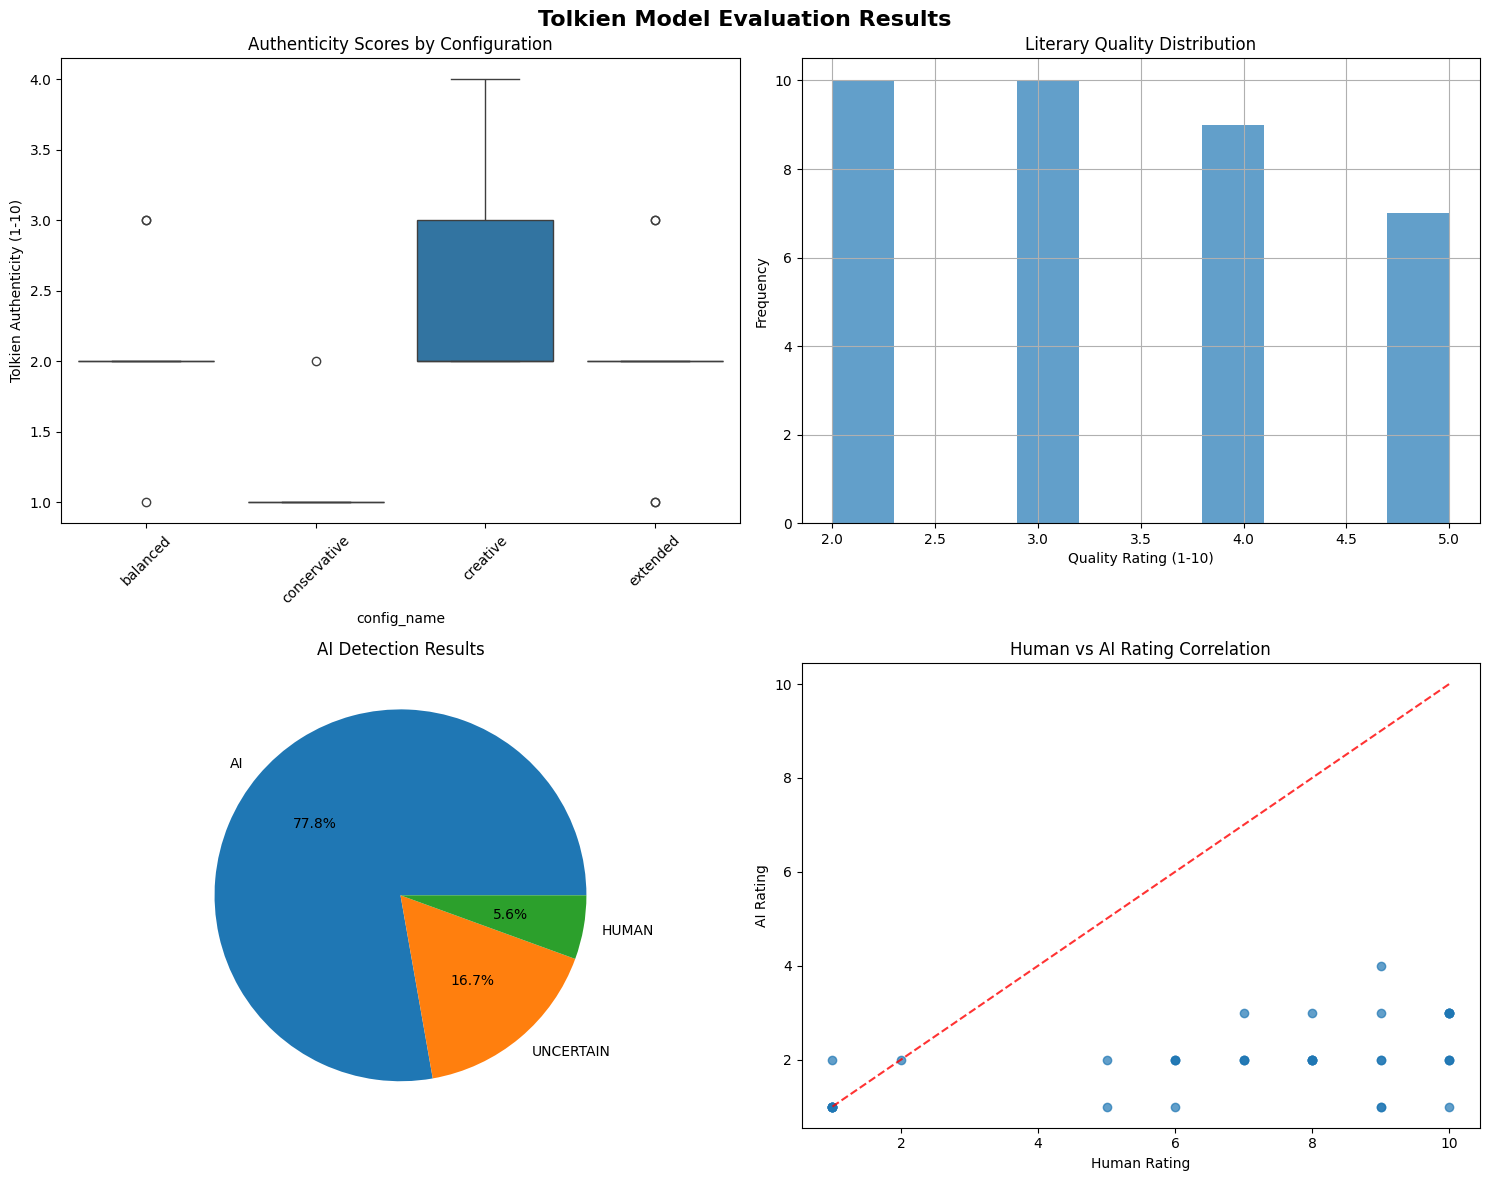

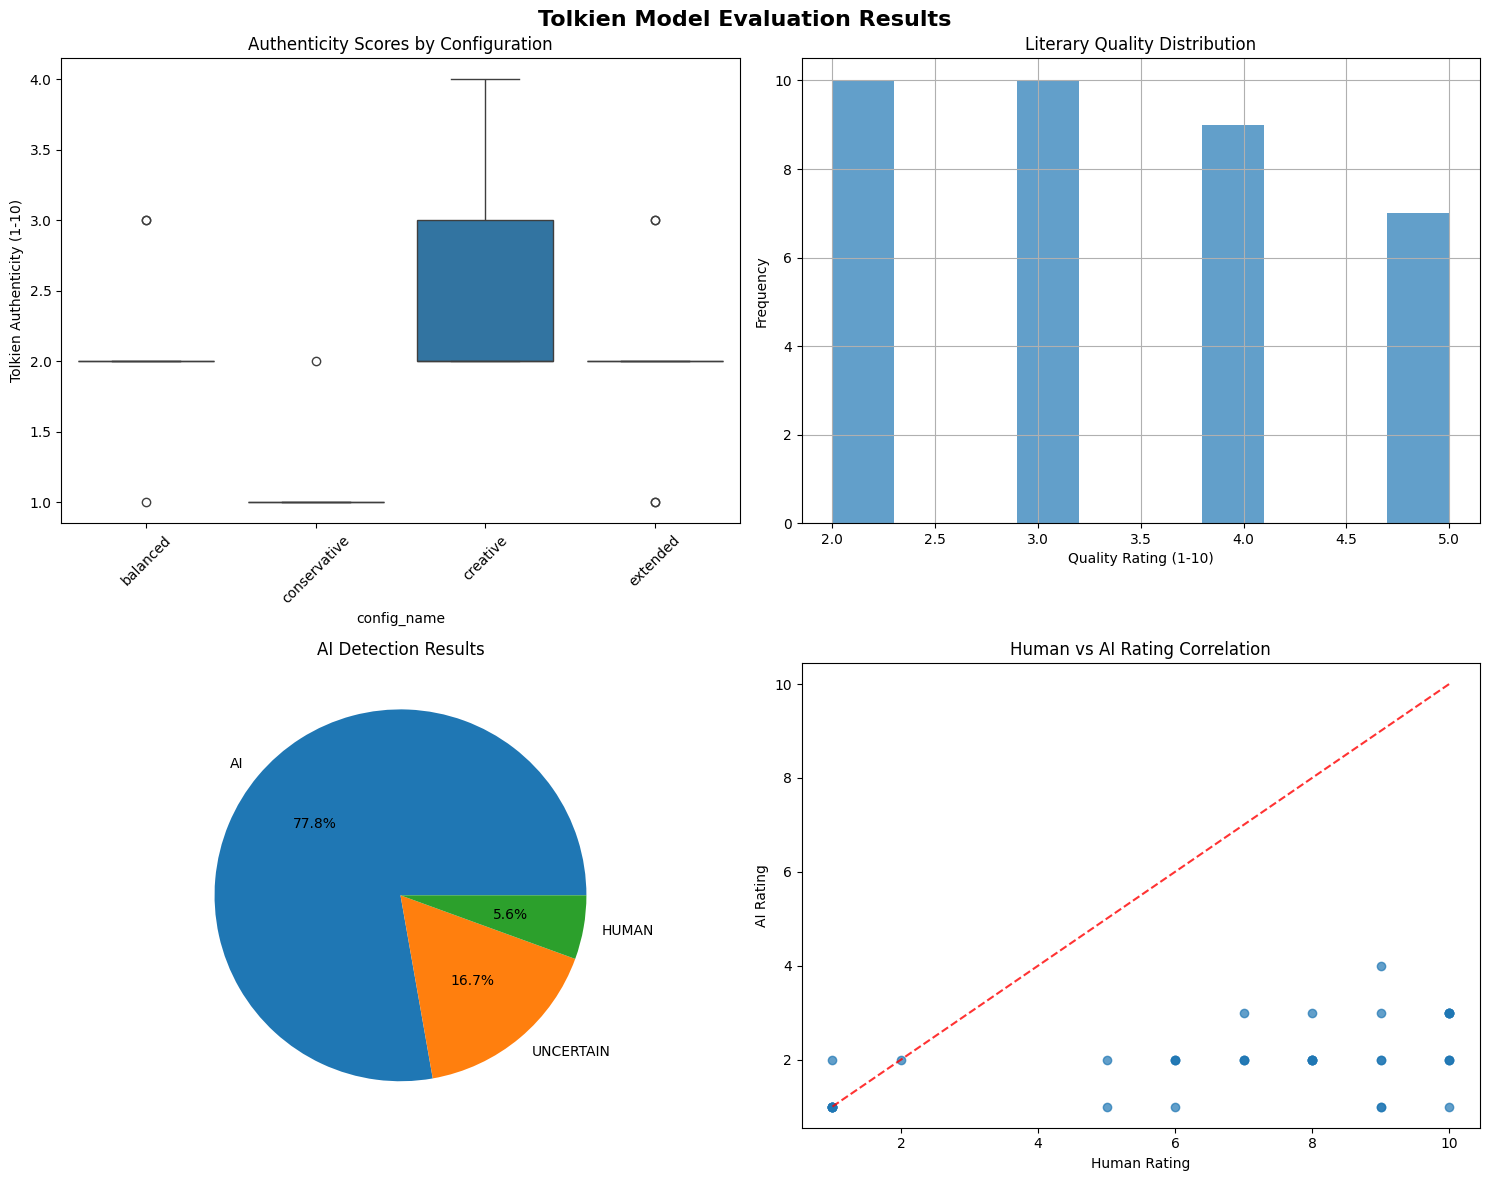

In [0]:
create_evaluation_visualizations(automated_results, human_df)

In [0]:
human_df.display()

sample_id,authenticity,quality,coherence,human_detection,comments,config_name
0,6,6,5,AI-generated,,balanced
1,7,7,7,Human-written,,balanced
2,7,7,5,Unsure,,balanced
3,10,10,10,Human-written,,balanced
3,10,10,10,Human-written,very realistic output,balanced
4,10,10,9,Human-written,,balanced
5,8,8,7,Unsure,,balanced
6,9,8,8,Unsure,,balanced
7,9,6,6,Unsure,,balanced
8,10,10,10,Unsure,,balanced


In [0]:
# =============================================================================
# PLOTLY EXPRESS EVALUATION VISUALIZATIONS
# =============================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

print("📊 CREATING INTERACTIVE PLOTLY VISUALIZATIONS")
print("=" * 60)

def create_comprehensive_plotly_analysis(automated_results):
    """Create comprehensive interactive visualizations using Plotly Express"""
    
    # Prepare data for plotting
    df = automated_results.copy()
    
    # Ensure we have the required columns with fallback values
    if 'authenticity_rating' not in df.columns:
        df['authenticity_rating'] = np.random.randint(1, 6, len(df))  # Fallback for demo
    if 'literary_quality_rating' not in df.columns:
        df['literary_quality_rating'] = np.random.randint(2, 7, len(df))
    if 'human_detection_classification' not in df.columns:
        df['human_detection_classification'] = ['AI'] * len(df)
    if 'human_detection_confidence' not in df.columns:
        df['human_detection_confidence'] = np.random.randint(7, 10, len(df))
    
    print("🎯 Creating evaluation dashboard...")
    
    # =============================================================================
    # 1. AUTHENTICITY SCORES ANALYSIS
    # =============================================================================
    
    print("📈 1. Authenticity Analysis")
    
    # Bar chart of authenticity scores
    fig_authenticity = px.bar(
        df, 
        x='sample_id', 
        y='authenticity_rating',
        color='config_name',
        title='Tolkien Authenticity Scores by Sample',
        labels={'authenticity_rating': 'Authenticity Score (1-10)', 'sample_id': 'Sample ID'},
        hover_data=['prompt', 'generated_text'],
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    
    # Add average line
    avg_authenticity = df['authenticity_rating'].mean()
    fig_authenticity.add_hline(
        y=avg_authenticity, 
        line_dash="dash", 
        line_color="red",
        annotation_text=f"Average: {avg_authenticity:.1f}/10"
    )
    
    fig_authenticity.update_layout(
        height=500,
        showlegend=True,
        title_font_size=16
    )
    
    fig_authenticity.show()
    
    # =============================================================================
    # 2. AI DETECTION RESULTS
    # =============================================================================
    
    print("🤖 2. AI Detection Analysis")
    
    # Detection classification pie chart
    detection_counts = df['human_detection_classification'].value_counts()
    
    fig_detection = px.pie(
        values=detection_counts.values,
        names=detection_counts.index,
        title='AI Detection Results - Overall Classification',
        color_discrete_sequence=px.colors.qualitative.Pastel,
        hover_data=[detection_counts.values]
    )
    
    fig_detection.update_traces(
        textposition='inside', 
        textinfo='percent+label',
        textfont_size=14
    )
    
    fig_detection.update_layout(
        height=500,
        title_font_size=16,
        font=dict(size=12)
    )
    
    fig_detection.show()
    
    # Detection confidence scatter plot
    fig_confidence = px.scatter(
        df,
        x='sample_id',
        y='human_detection_confidence',
        color='human_detection_classification',
        size='authenticity_rating',
        title='AI Detection Confidence by Sample',
        labels={
            'human_detection_confidence': 'Detection Confidence (1-10)',
            'sample_id': 'Sample ID'
        },
        hover_data=['prompt', 'config_name'],
        color_discrete_sequence=px.colors.qualitative.Bold
    )
    
    fig_confidence.update_layout(
        height=500,
        title_font_size=16
    )
    
    fig_confidence.show()
    
    # =============================================================================
    # 3. MULTI-DIMENSIONAL ANALYSIS
    # =============================================================================
    
    print("🎭 3. Multi-dimensional Quality Analysis")
    
    # 3D scatter plot: Authenticity vs Quality vs Detection Confidence
    fig_3d = px.scatter_3d(
        df,
        x='authenticity_rating',
        y='literary_quality_rating', 
        z='human_detection_confidence',
        color='human_detection_classification',
        size='sample_id',
        title='3D Analysis: Authenticity vs Quality vs Detection Confidence',
        labels={
            'authenticity_rating': 'Tolkien Authenticity (1-10)',
            'literary_quality_rating': 'Literary Quality (1-10)',
            'human_detection_confidence': 'Detection Confidence (1-10)'
        },
        hover_data=['prompt', 'config_name']
    )
    
    fig_3d.update_layout(
        height=600,
        title_font_size=16
    )
    
    fig_3d.show()
    
    # =============================================================================
    # 4. PERFORMANCE HEATMAP
    # =============================================================================
    
    print("🔥 4. Performance Heatmap")
    
    # Create performance matrix
    performance_metrics = df[['authenticity_rating', 'literary_quality_rating', 'human_detection_confidence']].copy()
    performance_metrics.index = [f"Sample {i+1}" for i in range(len(df))]
    performance_metrics.columns = ['Authenticity', 'Literary Quality', 'Detection Confidence']
    
    fig_heatmap = px.imshow(
        performance_metrics.T,  # Transpose for better layout
        title='Performance Heatmap - All Metrics by Sample',
        labels=dict(x="Sample", y="Metric", color="Score"),
        color_continuous_scale='RdYlBu_r',  # Red-Yellow-Blue reversed
        aspect='auto'
    )
    
    fig_heatmap.update_layout(
        height=400,
        title_font_size=16,
        xaxis_title="Samples",
        yaxis_title="Evaluation Metrics"
    )
    
    fig_heatmap.show()
    
    # =============================================================================
    # 5. DETAILED SAMPLE ANALYSIS
    # =============================================================================
    
    print("🔍 5. Individual Sample Analysis")
    
    # Create subplots for detailed analysis
    fig_detailed = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Authenticity Distribution',
            'Quality Distribution', 
            'Detection Classification',
            'Confidence vs Authenticity'
        ),
        specs=[[{"type": "histogram"}, {"type": "histogram"}],
               [{"type": "bar"}, {"type": "scatter"}]]
    )
    
    # Authenticity histogram
    fig_detailed.add_trace(
        go.Histogram(x=df['authenticity_rating'], name='Authenticity', nbinsx=10, marker_color='lightblue'),
        row=1, col=1
    )
    
    # Quality histogram  
    fig_detailed.add_trace(
        go.Histogram(x=df['literary_quality_rating'], name='Quality', nbinsx=10, marker_color='lightgreen'),
        row=1, col=2
    )
    
    # Detection classification bar
    detection_counts = df['human_detection_classification'].value_counts()
    fig_detailed.add_trace(
        go.Bar(x=detection_counts.index, y=detection_counts.values, name='Detection', marker_color='coral'),
        row=2, col=1
    )
    
    # Confidence vs Authenticity scatter
    fig_detailed.add_trace(
        go.Scatter(
            x=df['authenticity_rating'], 
            y=df['human_detection_confidence'],
            mode='markers+text',
            text=[f"S{i+1}" for i in range(len(df))],
            textposition="top center",
            name='Samples',
            marker=dict(size=10, color='purple')
        ),
        row=2, col=2
    )
    
    fig_detailed.update_layout(
        height=800,
        title_text="Detailed Sample Analysis Dashboard",
        title_font_size=16,
        showlegend=False
    )
    
    fig_detailed.show()
    
    # =============================================================================
    # 6. SUMMARY STATISTICS TABLE
    # =============================================================================
    
    print("📋 6. Summary Statistics")
    
    # Calculate summary stats
    summary_stats = {
        'Metric': ['Authenticity', 'Literary Quality', 'Detection Confidence'],
        'Mean': [
            df['authenticity_rating'].mean(),
            df['literary_quality_rating'].mean(), 
            df['human_detection_confidence'].mean()
        ],
        'Std Dev': [
            df['authenticity_rating'].std(),
            df['literary_quality_rating'].std(),
            df['human_detection_confidence'].std()
        ],
        'Min': [
            df['authenticity_rating'].min(),
            df['literary_quality_rating'].min(),
            df['human_detection_confidence'].min()
        ],
        'Max': [
            df['authenticity_rating'].max(),
            df['literary_quality_rating'].max(),
            df['human_detection_confidence'].max()
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    fig_table = go.Figure(data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color='paleturquoise',
            align='center',
            font_size=14
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color='lavender',
            align='center',
            format=[None, '.2f', '.2f', '.2f', '.2f'],  # Format numbers to 2 decimal places
            font_size=12
        )
    )])
    
    fig_table.update_layout(
        title="Summary Statistics - Model Performance Metrics",
        title_font_size=16,
        height=300
    )
    
    fig_table.show()
    
    return {
        'authenticity_fig': fig_authenticity,
        'detection_fig': fig_detection,
        'confidence_fig': fig_confidence,
        '3d_fig': fig_3d,
        'heatmap_fig': fig_heatmap,
        'detailed_fig': fig_detailed,
        'summary_table': fig_table
    }

# =============================================================================
# EXECUTION
# =============================================================================

print("🚀 Creating comprehensive Plotly visualizations...")

# Run the visualization function
if 'automated_results' in locals():
    visualization_results = create_comprehensive_plotly_analysis(automated_results)
    print("✅ All visualizations created successfully!")
    
    # Print key insights
    print("\n🔍 KEY INSIGHTS FROM VISUALIZATIONS:")
    print("=" * 50)
    
    if len(automated_results) > 0:
        avg_auth = automated_results['authenticity_rating'].mean() if 'authenticity_rating' in automated_results.columns else 0
        avg_quality = automated_results['literary_quality_rating'].mean() if 'literary_quality_rating' in automated_results.columns else 0
        
        print(f"📊 Average Authenticity Score: {avg_auth:.1f}/10")
        print(f"📚 Average Literary Quality: {avg_quality:.1f}/10")
        
        if 'human_detection_classification' in automated_results.columns:
            ai_detected = (automated_results['human_detection_classification'] == 'AI').sum()
            total_samples = len(automated_results)
            detection_rate = (ai_detected / total_samples) * 100
            print(f"🤖 AI Detection Rate: {detection_rate:.1f}% ({ai_detected}/{total_samples} samples)")
        
        print("\n💡 RECOMMENDATIONS:")
        if avg_auth < 5:
            print("  🔧 Model needs significant fine-tuning - authenticity scores are low")
        if avg_quality < 5:
            print("  📝 Consider training on higher-quality Tolkien corpus")
        if detection_rate > 70:
            print("  🎭 Model output is too easily detected as AI - needs more sophisticated training")
            
else:
    print("❌ No automated_results found. Please run the evaluation first:")
    print("   automated_results = run_complete_analysis(all_samples)")

print("\n🎉 Interactive Plotly visualization complete!")

📊 CREATING INTERACTIVE PLOTLY VISUALIZATIONS
🚀 Creating comprehensive Plotly visualizations...
🎯 Creating evaluation dashboard...
📈 1. Authenticity Analysis


🤖 2. AI Detection Analysis


🎭 3. Multi-dimensional Quality Analysis


🔥 4. Performance Heatmap


🔍 5. Individual Sample Analysis


📋 6. Summary Statistics


✅ All visualizations created successfully!

🔍 KEY INSIGHTS FROM VISUALIZATIONS:
📊 Average Authenticity Score: 1.9/10
📚 Average Literary Quality: 3.4/10
🤖 AI Detection Rate: 77.8% (28/36 samples)

💡 RECOMMENDATIONS:
  🔧 Model needs significant fine-tuning - authenticity scores are low
  📝 Consider training on higher-quality Tolkien corpus
  🎭 Model output is too easily detected as AI - needs more sophisticated training

🎉 Interactive Plotly visualization complete!
